In [1]:
# import packages
import sys
import os.path
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set()

from spykshrk.realtime.datatypes import Datatypes
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import trodes2SS
import scipy as sp
import sungod_util
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries

%load_ext autoreload
%autoreload 2

idx = pd.IndexSlice
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

In [851]:
# cell to read real-time hdf5 file

# 4-9 lfp config fix, 10 lfp tets, rip sd = 4, crossing tets = 4, ripple lockout 200 msec, posterior sum 50 msec, 20uV
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_10lfp_20uV_4_9_rip_200_50.rec_merged.h5'

# 4-16 real-time decoder using the full R Star tree for the whole session - not sure if this works
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_10lfp_20uV_4_16_load_tree.rec_merged.h5'

# 4-16 full R star tree, take 2 - tried to fix occupancy by loading complete occupancy
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_10lfp_20uV_4_16_load_tree_2.rec_merged.h5'

# 4-17 re-run remy day 20 epoch 2 with trans mat offset = 0.001
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_10lfp_20uV_4_17_offset.rec_merged.h5'

# 3-31 remy day 20 epoch 4 - better for arm 7 maybe, offset 0.0001
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_4_19tet_3_31_10lfp.rec_merged.h5'

# 4-23 remy day 20 epoch 4 - trans mat offset = 0.001
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_4_19tet_10lfp_4_23_offset.rec_merged.h5'

# 4-25 new whole ripple sum for real-time decoder, whole session
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_4_19tet_10lfp_4_25_replay_check_2.rec_merged.h5'

# 4-26 remy 20, 2: new whole ripple sum for real-time decoder, spike count for all ripple ends
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_4_19tet_10lfp_4_26_lockout_2.rec_merged.h5'

# 4-27 remy 20, 2: 20 ripple tetrodes, sd = 4, num tets = 6
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_4_27_20lfp.rec_merged.h5'

# 4-28 remy 20,2 check LFP timing with 20 LFP tets
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_4_27_20lfp_timing.rec_merged.h5'

# 4-28 remy 21,2 whole session - no detected ripples - some problem with playback
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_21_2_19tet_4_28_20lfp_whole.rec_merged.h5'

# 4-29 remy 21,2 encode on whole session 
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_21_2_19tet_4_29_20lfp_whole.rec_merged.h5'

# 4-29 remy 21,2 encode only up to 24:15
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_21_2_19tet_4_29_20lfp_partial.rec_merged.h5'

# 4-30 remy 20,2 update LFP baseline every 1 min
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_4_30_20lfp_1min_base.rec_merged.h5'

# 4-30 remy 20,2 update LFP baseline every 5 min
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_4_30_20lfp_5min_base.rec_merged.h5'

# 5-1 remy 20,2 update LFP baseline 5 min, update spike count 5min (75% as baseline?)
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_1_20lfp_5minlfp_5minspk.rec_merged.h5'

# 5-2 remy 20, sleep session 1
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_sleep_19tet_5_2_20lfp_sleep_base.rec_merged.h5'

# 5-2 remy 21, sleep session 1
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_21_sleep_19tet_5_2_20lfp_base.rec_merged.h5'

# 5-4 remy 20, sleep 1, introduce spike count st dev
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_sleep_19tet_5_4_20lfp_std.rec_merged.h5'

# 5-4 remy 20, 2, introduce spike count st dev whole session - didnt work, wrong config file
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_4_20lfp_spk_std.rec_merged.h5'

# 5-4 remy 20, 2, 3 of 5 less than spk count threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_4_20lfp_spk_std_3.rec_merged.h5'

# 5-5 remy 20, 2, 2 of 5 less than spk count threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_5_20lfp_spk_std.rec_merged.h5'

# 5-6 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_6_2of5_200ms.rec_merged.h5'

# 5-5 remy 20, 2, 2 of 5 spk count threshold, 100 msec lockout
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_5_2of5_100ms.rec_merged.h5'

# 5-6 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >2 posterior time bin
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_6_2of5_200ms_post_bin.rec_merged.h5'

# 5-6 remy 20, 2, 2 of 5 spk count threshold, 50 msec lockout, >2 posterior time bin
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_6_2of5_50ms_post_bin.rec_merged.h5'

# 5-6 remy 20, 2, 2 of 5 spk count threshold, 50 msec lockout, >0 posterior time bin
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_6_2of5_200ms_post0.rec_merged.h5'

# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_7_vel_4.rec_merged.h5'

# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4, sd = 5
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_7_vel4_sd5.rec_merged.h5'

# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4, static base
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_7_vel4_static_base.rec_merged.h5'

# 5-8 jaq ptp camera test
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/jap_ptp_5_8.rec_merged.h5'

# 5-9 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel 4, static base, trodes 1&2
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_8_trodes1and2.rec_merged.h5'

# 5-11 remy 20, 2, trodes 1&2, spike threshold = 149 uV
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_11_trodes1and2_149_whole.rec_merged.h5'

# 5-10 remy 20, 2, trodes 1&2, rip bin spike count > 0
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_10_trodes1and2_rip_spike_bin.rec_merged.h5'

# 5-11 remy 20, 2, trodes 1&2, spike threshold = 149 uV, no rip bin spike count
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_11_trodes1and2_149_whole_2.rec_merged.h5'

# 5-12 remy 20, 2, trodes 1&2, spike threshold = 150 uV, rip bin spike count > 0
hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_20_2_19tet_5_12_trodes1and2_150_whole.rec_merged.h5'

store = pd.HDFStore(hdf_file, mode='r')

In [618]:
# 5-6 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, post time bin > 0
#encoder_data11 = store['rec_3']
#decoder_data11 = store['rec_4']
decoder_missed_spikes17 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data17 = store['rec_7']
ripple_data17 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout17 = store['rec_11']
stim_message17 = store['rec_12']
#timing1 = store['rec_100']

In [641]:
# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4
#encoder_data11 = store['rec_3']
#decoder_data11 = store['rec_4']
decoder_missed_spikes18 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data18 = store['rec_7']
#ripple_data17 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout18 = store['rec_11']
stim_message18 = store['rec_12']
#timing1 = store['rec_100']

In [657]:
# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4, sd = 5
#encoder_data11 = store['rec_3']
#decoder_data11 = store['rec_4']
decoder_missed_spikes19 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data19 = store['rec_7']
#ripple_data17 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout19 = store['rec_11']
stim_message19 = store['rec_12']
#timing1 = store['rec_100']

In [756]:
# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4, static base
encoder_data20 = store['rec_3']
#decoder_data11 = store['rec_4']
decoder_missed_spikes20 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data20 = store['rec_7']
#ripple_data17 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout20 = store['rec_11']
stim_message20 = store['rec_12']
#timing1 = store['rec_100']

In [692]:
# 5-7 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel_thresh 4, static base
encoder_data21 = store['rec_3']
decoder_data21 = store['rec_4']
decoder_missed_spikes21 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data21 = store['rec_7']
ripple_data21 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout21 = store['rec_11']
stim_message21 = store['rec_12']
#timing1 = store['rec_100']

In [754]:
# 5-9 remy 20, 2, 2 of 5 spk count threshold, 200 msec lockout, >0 posterior time bin, vel 4, static base, trodes 1&2
encoder_data22 = store['rec_3']
#decoder_data22 = store['rec_4']
decoder_missed_spikes22 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data22 = store['rec_7']
#ripple_data22 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout22 = store['rec_11']
stim_message22 = store['rec_12']
#timing1 = store['rec_100']

In [823]:
# 5-11 remy 20, 2, trodes 1&2, spike threshold = 149 uV
encoder_data23 = store['rec_3']
#decoder_data22 = store['rec_4']
#decoder_missed_spikes22 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data23 = store['rec_7']
#ripple_data22 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout23 = store['rec_11']
stim_message23 = store['rec_12']
#timing1 = store['rec_100']

In [806]:
# 5-10 remy 20, 2, trodes 1&2, rip bin spike count > 0
#encoder_data23 = store['rec_3']
#decoder_data22 = store['rec_4']
#decoder_missed_spikes22 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data24 = store['rec_7']
#ripple_data22 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout24 = store['rec_11']
stim_message24 = store['rec_12']
#timing1 = store['rec_100']

In [842]:
# 5-11 remy 20, 2, trodes 1&2, spike threshold = 149 uV, no rip bin spike count
#encoder_data23 = store['rec_3']
#decoder_data22 = store['rec_4']
#decoder_missed_spikes22 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data25 = store['rec_7']
#ripple_data22 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout25 = store['rec_11']
stim_message25 = store['rec_12']
#timing1 = store['rec_100']

In [897]:
# 5-12 remy 20, 2, trodes 1&2, spike threshold = 150 uV, rip bin spike count > 0
#encoder_data23 = store['rec_3']
decoder_data26 = store['rec_4']
#decoder_missed_spikes22 = store['rec_5']
#likelihood_data11 = store['rec_6']
occupancy_data26 = store['rec_7']
#ripple_data22 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout26 = store['rec_11']
stim_message26 = store['rec_12']
#timing1 = store['rec_100']

In [824]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
encoder_data23.shape

(1397465, 146)

In [801]:
marks_reset = marks.reset_index()
marks_reset[(marks_reset['timestamp']>39700448+1958987) & (marks_reset['timestamp']<59948440+1958987)].shape


(234952, 9)

In [783]:
print(stim_lockout20[stim_lockout20['lockout_state']==1].shape)
print(stim_lockout22[stim_lockout22['lockout_state']==1].shape)
print(encoder_data20.shape)
print(encoder_data22.shape)
print(occupancy_data20.shape)
print(occupancy_data22.shape)
print(decoder_missed_spikes20.shape)
print(decoder_missed_spikes22.shape)

(1054, 8)
(1064, 8)
(1363949, 146)
(1378382, 146)
(121776, 146)
(121785, 146)
(28730, 5)
(29353, 5)


In [ ]:
# plot mark space for real-time spikes
import matplotlib.colors as mcolors

tetrode_list = [4,6,9,10,11,12,13,14,15,20,21,22,23,24,25,26,28,29,30]

for tet in tetrode_list:
    #tetrode = 30
    # offline marks
    #spikes_tet_30 = marks_realtime.xs(tet,level='elec_grp_id')
    # real-time marks
    spikes_tet_30 = encoder_data22[encoder_data22['elec_grp_id']==tet]

    #spikes_tet_30 = spk_test2.xs(30,level='elec_grp_id')

    plt.rcParams["figure.figsize"] = [8,4]
    fig, axs = plt.subplots(2,3)
    axs[0,0].hist2d(spikes_tet_30['ch1'],spikes_tet_30['ch2'],bins=500,norm=mcolors.PowerNorm(.05))
    axs[0,0].title.set_text(f'{tet} c00 v c01')
    axs[0,1].hist2d(spikes_tet_30['ch1'],spikes_tet_30['ch3'],bins=500,norm=mcolors.PowerNorm(.05))
    axs[0,1].title.set_text(f'{tet} c00 v c02')
    axs[0,2].hist2d(spikes_tet_30['ch1'],spikes_tet_30['ch4'],bins=500,norm=mcolors.PowerNorm(.05))
    axs[0,2].title.set_text(f'{tet} c00 v c03')
    axs[1,0].hist2d(spikes_tet_30['ch2'],spikes_tet_30['ch3'],bins=500,norm=mcolors.PowerNorm(.05))
    axs[1,0].title.set_text(f'{tet} c01 v c02')
    axs[1,1].hist2d(spikes_tet_30['ch2'],spikes_tet_30['ch4'],bins=500,norm=mcolors.PowerNorm(.05))
    axs[1,1].title.set_text(f'{tet} c01 v c03')
    axs[1,2].hist2d(spikes_tet_30['ch3'],spikes_tet_30['ch4'],bins=500,norm=mcolors.PowerNorm(.05))
    axs[1,2].title.set_text(f'{tet} c02 v c03')
    plt.title((f'Tet {tet}.'))
    print(spikes_tet_30.shape)

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
ripple_data17[0:10]

<IPython.core.display.Javascript object>


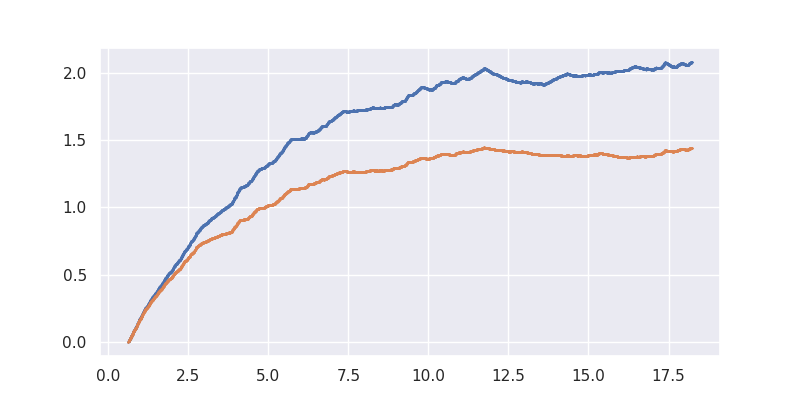

In [347]:
# this shows spike count mean and std during sleep session
# remy 20 sleep session 1

plt.figure(figsize=(8,4))
#plt.scatter(occupancy_data5['bin_timestamp'].values,occupancy_data5['linear_pos'].values,s=1)
plt.scatter(stim_lockout10['timestamp'].values/30000/60,stim_lockout10['tets_above_thresh'].values,s=.1)
plt.scatter(stim_lockout10['timestamp'].values/30000/60,stim_lockout10['big_rip_message_sent'].values,s=.1)


In [404]:
# real-time ripple length

stim_lockout11_test = stim_lockout11.copy()
stim_lockout11_test = stim_lockout11_test[stim_lockout11_test['lockout_state']<2]
stim_lockout11_test['rip_len'] = stim_lockout11_test['timestamp'].diff()
rt_rip_length_3bins = stim_lockout11_test[stim_lockout11_test['lockout_state']==0]

stim_lockout12_test = stim_lockout12.copy()
stim_lockout12_test = stim_lockout12_test[stim_lockout12_test['lockout_state']<2]
stim_lockout12_test['rip_len'] = stim_lockout12_test['timestamp'].diff()
rt_rip_length_2bins = stim_lockout12_test[stim_lockout12_test['lockout_state']==0]

<IPython.core.display.Javascript object>


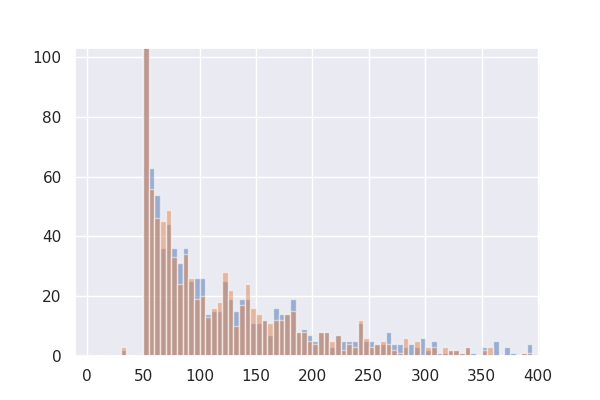

(array([  0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0., 438.,
         56.,  46.,  45.,  49.,  33.,  24.,  34.,  26.,  19.,  20.,  13.,
         16.,  18.,  28.,  22.,  10.,  17.,  24.,  16.,  14.,  12.,  11.,
         12.,  12.,  14.,  15.,   8.,   8.,   5.,   4.,   8.,   8.,   5.,
          7.,   2.,   4.,   3.,  12.,   6.,   3.,   4.,   5.,   4.,   2.,
          1.,   6.,   0.,   5.,   0.,   3.,   3.,   0.,   3.,   2.,   2.,
          1.,   3.,   0.,   0.,   2.,   3.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
        260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
        325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385,
        390, 395]),
 <

In [405]:
# plot ripple length 3 of 5 bins below thresh vs 2 of 5 bins

plt.figure(figsize=(6,4))
plt.hist(rt_rip_length_3bins['rip_len'].values/30,bins=np.arange(0,400,5),alpha=0.5)
plt.hist(rt_rip_length_2bins['rip_len'].values/30,bins=np.arange(0,400,5),alpha=0.5)



In [4]:
# Remy: offline decode with trans mat offset = 0.001
file_path = '/stelmo/mcoulter/raw_data/remy/remy_20_2_shuffle_0_posteriors_4_18_offline_offset.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors = store[main_path] 

In [301]:
# Remy: day 21, eposh 2, encode whole session
file_path = '/stelmo/mcoulter/raw_data/remy/remy_21_2_shuffle_0_posteriors_4_28_offline_whole.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path] 

In [316]:
# Remy: day 21, eposh 2, encode part session
file_path = '/stelmo/mcoulter/raw_data/remy/remy_21_2_shuffle_0_posteriors_4_28_offline_partial.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors3 = store[main_path] 

In [797]:
# get linear position for offline
# TO DO: update for location of new linearized position files

#### Define parameters
rat_name = 'remy'
day =  20     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 2   # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/stelmo/mcoulter/'
#path_base = '/mnt/vortex/mcoulter/'
#raw_directory = path_base + 'raw_data/' + rat_name + '/'
raw_directory = '/stelmo/anna/remy/filterframework/'
# old linearization
#linearization_path = raw_directory + 'decoding/'
# new linearization
linearization_path = '/stelmo/mcoulter/raw_data/'
day_ep = str(day) + '_' + str(epoch)

#tetlist = None
# to match real-time
tetlist = [4,6,9,10,11,12,13,14,15,20,21,22,23,24,25,26,28,29,30]
#tetlist = [4]
tetrodes= tetlist

pos_bin_size = 5
velocity_thresh_for_enc_dec = 4
velocity_buffer = 0
shift_amt_for_shuffle = 0
use_enc_as_dec = 1   #if you want to use the encoding marks as the decoding marks
discrete_tm_val=.99   # for classifier

# IMPORT and process data
#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)
# Import marks
marks = datasrc.import_marks()
print('original length: '+str(marks.shape[0]))
# OPTIONAL: to reduce mark number, can filter by size. Current detection threshold is 100  
marks = trodes2SS.threshold_marks(marks, maxthresh=2000,minthresh=150)
# remove any big negative events (artifacts?)
marks = trodes2SS.threshold_marks_negative(marks, negthresh=-999)
print('after filtering: '+str(marks.shape[0]))

# Import trials
trials = datasrc.import_trials()
# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. 
# new linear: linearization_path + rat_name
# old linear: linearization_path 
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'
linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
track_segment_ids = np.load(lin_output2)
print('Linearization found. Loading it')

# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)

# for using new linearization nodes
binned_arm_coords[:,1] = 1+binned_arm_coords[:,1]
print(binned_arm_coords)
#pos_bin_delta = 1

# Import ripples
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))


Duplicate marks found (and removed): 0
original length: 3098153
0 above 2000uV events removed
1686842 below 150uV events removed
0 below -999uV events removed
after filtering: 1411311
Linearization found. Loading it
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  63.
  68.  73.  78.  83.  88.  93.  98. 103. 108. 113. 118. 123. 128. 133.
 138. 141. 146. 151. 156. 161. 166. 171. 176. 181. 186. 191. 196. 201.
 206. 211. 216. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270.
 275. 280. 285. 290. 295. 300. 302. 307. 312. 317. 322. 327. 332. 337.
 342. 347. 352. 357. 362. 367. 372. 377. 382. 387. 392. 397. 402. 407.
 412. 417. 422. 427. 432. 437. 442. 447. 452. 457. 461. 466. 471. 476.
 481. 486. 491. 496. 501. 506. 511. 516. 521. 526. 531. 536. 541. 542.
 547. 552. 557. 562. 567. 572. 577. 582. 587. 592. 597. 602. 607. 612.
 617. 620. 625. 630. 635. 640. 645. 650. 655. 660. 665. 670. 675. 680.
 685.]
[[  0   8]
 [ 13  25]
 [ 29  41]
 [ 45  57]
 [ 62  74]
 [ 78  90]
 

In [653]:
# Import ripples - try changing velocity threshold
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))


Rips less than velocity thresh: 1256


<IPython.core.display.Javascript object>


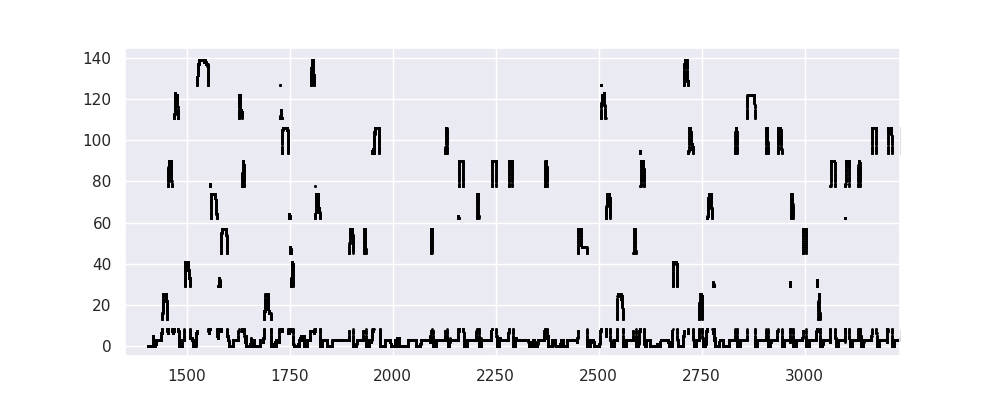

In [318]:
%matplotlib notebook
# look at trials for remy day 20 epoch 4
binned_linear_pos_plot = binned_linear_pos.copy()
binned_linear_pos_plot.reset_index(inplace=True)
mvt_time = binned_linear_pos_plot[binned_linear_pos_plot['linvel_flat'].values>4]
plt.figure(figsize=(10,4))
plt.scatter(binned_linear_pos_plot['time'].values,binned_linear_pos_plot['linpos_flat'].values,s=1,c='black')
#plt.scatter(mvt_time['time'].values,mvt_time['linpos_flat'].values,s=1,c='red')


In [43]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
# stim_lockout timestamp_shift is the 70 msec shift to account for delay in realtime rip detection (-2100)
# currently it looks like the shift is set to 0

# which files to use
stim_message_file = stim_message1
stim_lockout_file = stim_lockout1
decoder_data_file = decoder_data1

stim_message_1 = stim_message_file.copy()
stim_message_2 = stim_message_1.drop(['rec_ind','spike_timestamp','time','lfp_timestamp',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message_2
decode_to_merge = decoder_data_file.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message_2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout_file.copy()
stim_lockout_1['timestamp_shift'] = stim_lockout_file['timestamp']
stim_lockout_1['bin_timestamp'] = stim_lockout_1['timestamp_shift']

stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','tets_above_thresh',
                                      'big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout.shape

(819323, 171)

In [ ]:
# several ripples are missing any entry for shortcut_message
# and several are duplicated
# okay figured this out - was problem with 20 msec delay - no longer using this
# duplicates are from allowed time for sum after ripple detection
plt.figure(figsize=(5,3))
plt.hist(stim_message_file['ripple_number'].diff().values,bins=np.arange(0,5))

In [348]:
list(merged_decoder_lockout)
decoder_missed_spikes2.shape

(26044, 5)

<IPython.core.display.Javascript object>


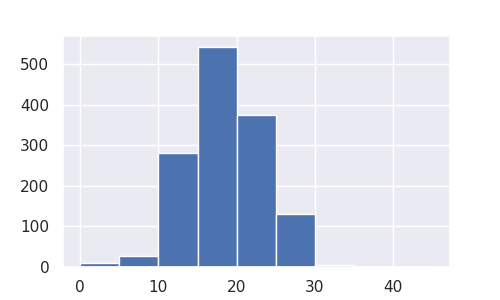

(array([ 11.,  28., 280., 542., 375., 130.,   6.,   0.,   0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45]),
 <a list of 9 Patch objects>)

In [130]:
stim_message
plt.figure(figsize=(5,3))
plt.hist(stim_message2['delay'].values,bins=np.arange(0,50,5))

In [45]:
# not using currently - use cell below
# subset of decoder_data to plot - loop through each ripple
# how can we just generate the images for the mismatched ripples??

# which files to use
stim_message_file = stim_message1
stim_lockout_file = stim_lockout1
decoder_data_file = decoder_data1

# new: stim_message
#realtime_posterior_sum_all = np.zeros((len(stim_message_file),4))
# original: stim_lockout
realtime_posterior_sum_all = np.zeros((len(stim_lockout_file[stim_lockout_file['lockout_state']==1]),5))

counter = -1
summarize_all_rips = True

# we could use stim_message lfp_timestamp instead here - it is ahead by 100-200 timestamps
#for timestamp in stim_message_file['lfp_timestamp'].values:
# original: used stim_lockout
for timestamp in stim_lockout_file[stim_lockout_file['lockout_state']==1]['timestamp'].values:
    counter += 1
    #print(timestamp)
    #if counter in non_matching['realtime_rip'].values:
        #print(counter)
        
    # check replay content of non-matching ripples
    #if counter in nonmatching_offline_rips['lockout_num'].values:
        #print(counter)
        
    # check replay content of matching ripples
    #if counter in matching_offline_rips['lockout_num'].values:
        #print(counter)        
    
    if summarize_all_rips:
        #print(timestamp,)
    #posterior from decode/stim message merged table
        merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                            (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
        merged_to_plot.set_index('bin_timestamp',inplace=True)
        posterior_only_merged = merged_to_plot.iloc[:,24:161]
        
        # ripple time - generated from lockout_state
        # note: this does not inlcude the 70 msec before ripple detection
        # lockout_state changes at posterior_lock end, so this should post_lock (now 50 msec)
        ripples_to_plot = merged_to_plot.reset_index()
        ripple_times_rt = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

        # get timestamp when shortcut message was sent - try to just isolate single ripple
        # bin_timestamp will show the delay - it will appear before the start of the ripple
        # in contrast, lfp_timestamp would line up exactly with ripple start
        shortcut_message_to_plot = stim_message_file[(stim_message_file['lfp_timestamp'] > timestamp-30*30) & 
                                             (stim_message_file['lfp_timestamp'] < timestamp+30*100)]
        merged_to_plot_index = merged_to_plot.reset_index()
        # loop through multiple entries in shortcut_message
        shortcut_message_times = np.zeros(shortcut_message_to_plot.shape[0])
        for i in np.arange(0,shortcut_message_to_plot.shape[0]):
            shortcut_message_times[i] = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
            #print(shortcut_message_to_plot['box'][i:i+1].values,shortcut_message_to_plot['arm1'][i:i+1].values,
            #      shortcut_message_to_plot['arm2'][i:i+1].values,shortcut_message_to_plot['arm3'][i:i+1].values,
            #      shortcut_message_to_plot['arm4'][i:i+1].values,shortcut_message_to_plot['arm5'][i:i+1].values,
            #      shortcut_message_to_plot['arm6'][i:i+1].values,shortcut_message_to_plot['arm7'][i:i+1].values,
            #      shortcut_message_to_plot['arm8'][i:i+1].values)
        #shortcut_message_times = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'].values].tolist()
        shortcut_messages = shortcut_message_to_plot['shortcut_message_sent'].values*123
    
        #posterior_only
        #print(posterior_only_merged.shape)
    
        #plot heatmap with posterior surrounding each ripple
        post_heatmap = posterior_only_merged.transpose()
        post_heatmap = post_heatmap.iloc[::-1]
    
        #plot title: include ripple number, max arm, and delay
        title_index = int(len(merged_to_plot)*0.6)
        max_arm = merged_to_plot[title_index:title_index+1]['posterior_max_arm'].values
        #ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
        #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
        #ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['ripple_number_y'].values
        ripple_num = merged_to_plot[title_index:title_index+1]['lockout_num'].values
        message_delay = np.around(merged_to_plot[title_index:title_index+1]['delay'].values,decimals=0)
        real_pos = merged_to_plot[title_index:title_index+1]['real_pos'].values
        #offline_max = non_matching[(non_matching['realtime_rip']>=counter) & 
        #                           (non_matching['realtime_rip']<counter+1)]['off_max_arm'].values
        offline_max = 0
        #print('ripple:',ripple_num,'timestamp',timestamp-30*300,timestamp+30*300)

        # fill in current row of posterior sum array - seems to work
        realtime_posterior_sum_all[counter,0] = ripple_num
        realtime_posterior_sum_all[counter,1] = max_arm
        realtime_posterior_sum_all[counter,2] = shortcut_message_to_plot.shape[0]-1
        realtime_posterior_sum_all[counter,3] = message_delay
        realtime_posterior_sum_all[counter,4] = real_pos
    
        #plt.figure(figsize=(8,4))
        #plt.title(f'Real-time posterior, Ripple {ripple_num} RT max {max_arm} Off max {offline_max} Delay {message_delay}')
        #ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        ##gap lines need to be inverse of where you would expect
        #ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
        ##ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
        ##ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
        #ax.vlines(ripple_times_rt,lw=1,color='w',alpha=0.3,*ax.get_ylim())
        ## plot time when statescript message was sent, 100 = sent, 0 = not send
        ## if X is missing it means the timestamp didn't match perfectly above
        ## could take delay into account here: add delay/5
        #ax.scatter(shortcut_message_times+message_delay/5,124-shortcut_messages,s=40,color='yellow',marker='x')

        # try to find ripple number
        #ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['ripple_number_y'].values+20,s=1,alpha=0.5,color='red')
        # need to convert sent_message_list into values starting where beginning of this plot is x=0
        #ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())
    
        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/remy_20_2_realtime_2_20_nonmatching_{ripple_num}_timestamp_{timestamp}.jpg')

# convert offline_posterior_sum_all array to pandas
# only run first time through, before matching
realtime_post_sum_summary = pd.DataFrame(data=realtime_posterior_sum_all,columns=('realtime_rip','rt_max_arm',
                                                                                  'rt_two_messages','rt_delay',
                                                                                  'real_pos'))
realtime_post_sum_summary.shape


(1215, 5)

In [898]:
# more simple and accurate ripple and replay summary for timing
# just join stim_lockout and stim_message on lockout_num

# which files to use
stim_message_file = stim_message26
stim_lockout_file = stim_lockout26

realtime_ripple_starts = stim_lockout_file[stim_lockout_file['lockout_state']==1]

lockout_message_joined = pd.merge(realtime_ripple_starts, stim_message_file, how='inner',
                                  left_on='lockout_num', right_on = 'ripple_number',
                                  suffixes=('_rip', '_msg'))
lockout_message_joined['rip_space'] = (lockout_message_joined['timestamp'].diff())/30
lockout_message_joined.shape


(995, 36)

In [895]:
list(lockout_message_joined)
stim_message23.shape

(995, 27)

In [ ]:
# summary counts for real-time replay assignment
pd.set_option('display.max_rows', 12)
realtime_post_sum_summary_count = lockout_message_joined.copy()
print(realtime_post_sum_summary_count.shape)
#realtime_post_sum_summary_count = realtime_post_sum_summary_count[realtime_post_sum_summary_count['realtime_rip']>0]
#print(realtime_post_sum_summary_count.shape)
realtime_post_sum_summary_count = realtime_post_sum_summary_count[realtime_post_sum_summary_count['real_pos']<10]
print(realtime_post_sum_summary_count.shape)
realtime_post_sum_summary_count
realtime_post_sum_summary_count['posterior_max_arm'].value_counts()

In [ ]:
# plot histogram of offline replay arms
replay_histogram = lockout_message_joined.copy()
#replay_histogram = replay_histogram[replay_histogram['taskState']==2]
plt.figure(figsize=(6,4))
plt.hist(replay_histogram['posterior_max_arm'].values,bins=np.arange(0,101))
plt.title('Real-time replay assignments')
print(replay_histogram.shape)


In [872]:
# plot cumulative replays of two example arms and all other replays
# this seems to work
# add taskState

replay_message_file = stim_message23
replays_to_plot = np.zeros((len(replay_message_file),4))

arm_1_count = 0
arm_2_count = 0
other_replay_count = 0

for i in np.arange(len(replay_message_file)):
    if (replay_message_file[i:i+1]['posterior_max_arm'].values == 1 and
        replay_message_file[i:i+1]['taskState'].values == 1):
        arm_1_count += 1
        replays_to_plot[i,0] = replay_message_file[i:i+1]['bin_timestamp'].values
        replays_to_plot[i,1] = replay_message_file[i:i+1]['taskState'].values
        replays_to_plot[i,2] = arm_1_count
        replays_to_plot[i,3] = 1
    elif (replay_message_file[i:i+1]['posterior_max_arm'].values == 2 and
          replay_message_file[i:i+1]['taskState'].values == 1):
        arm_2_count += 1
        replays_to_plot[i,0] = replay_message_file[i:i+1]['bin_timestamp'].values
        replays_to_plot[i,1] = replay_message_file[i:i+1]['taskState'].values
        replays_to_plot[i,2] = arm_2_count
        replays_to_plot[i,3] = 2
    elif replay_message_file[i:i+1]['taskState'].values == 1:
        other_replay_count += 1
        replays_to_plot[i,0] = replay_message_file[i:i+1]['bin_timestamp'].values
        replays_to_plot[i,1] = replay_message_file[i:i+1]['taskState'].values
        replays_to_plot[i,2] = other_replay_count
        replays_to_plot[i,3] = 99

replays_to_plot_df = pd.DataFrame(data=replays_to_plot,columns=('bin_timestamp','taskState',
                                                                'replay_count','replay_arm'))

In [ ]:
pd.set_option('display.max_rows', 10)

replays_to_plot_df

<IPython.core.display.Javascript object>


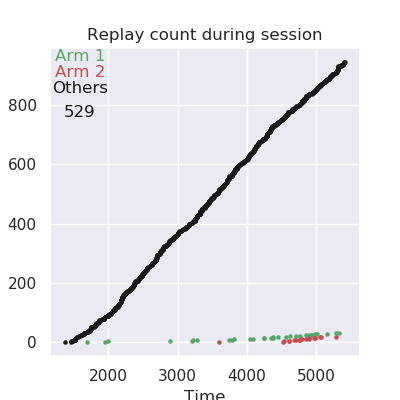

Text(0.2, 0.7, '529')

In [885]:
# now need to scatter plot replays_to_plot
plt.figure(figsize=(4,4))
plt.scatter(replays_to_plot_df[replays_to_plot_df['replay_arm']==1]['bin_timestamp'].values/30000,
            replays_to_plot_df[replays_to_plot_df['replay_arm']==1]['replay_count'].values,s=5,c='g')
plt.scatter(replays_to_plot_df[replays_to_plot_df['replay_arm']==2]['bin_timestamp'].values/30000,
            replays_to_plot_df[replays_to_plot_df['replay_arm']==2]['replay_count'].values,s=5,c='r')
plt.scatter(replays_to_plot_df[replays_to_plot_df['replay_arm']==99]['bin_timestamp'].values/30000,
            replays_to_plot_df[replays_to_plot_df['replay_arm']==99]['replay_count'].values,s=5,c='k')
plt.figtext(0.2, 0.84, "Arm 1", ha="center", va="bottom", size="medium",color="g")
plt.figtext(0.2, 0.8, "Arm 2", ha="center", va="bottom", size="medium",color="r")
plt.figtext(0.2, 0.76, "Others", ha="center", va="bottom", size="medium",color="k")
plt.xlabel('Time')
plt.title('Replay count during session')

plt.figtext(0.2, 0.7, decoder_missed_spikes21.shape[0], ha="center", va="bottom", size="medium",color="k")
#plt.figtext(0.2, 0.76, "Others", ha="center", va="bottom", size="medium",color="k")

#plt.savefig('/stelmo/mcoulter/realtime_next_rat/test_plot.pdf')
#plt.close()


In [ ]:
# plot to display number: example total spikes and dropped spikes
plt.figure(figsize=(4,4))
plt.scatter([0,1,2],[0,0,0])

plt.figtext(0.5, 0.8, "Total spikes", ha="center", va="bottom", size="medium",color="k")
plt.figtext(0.5, 0.75, encoder_data21.shape[0], ha="center", va="bottom", size="medium",color="k")
plt.figtext(0.5, 0.65, "Dropped spikes", ha="center", va="bottom", size="medium",color="k")
plt.figtext(0.5, 0.6, decoder_missed_spikes21.shape[0], ha="center", va="bottom", size="medium",color="k")

plt.ylim(0,10)
plt.xlim(0,10)

#plt.savefig('/stelmo/mcoulter/realtime_next_rat/spike_count.pdf')
#plt.close()

In [ ]:
lockout_message_joined

In [ ]:
#posterior_to_plot.index[(posterior_to_plot['bin_timestamp'].values >
#                         lockout_message_joined[index:index+1]['timestamp'].values) &
#                       (posterior_to_plot['bin_timestamp'].values <
#                         lockout_message_joined[index:index+1]['timestamp'].values+250)][0]
#index
#posterior_to_plot
stim_message_file[30:40]
# timestamp should be centered on 50713650
#posterior_to_plot[55:65]
list(decoder_data26)
decoder_data26.iloc[:,25:162]
posterior_to_plot.iloc[:,26:164]

<IPython.core.display.Javascript object>


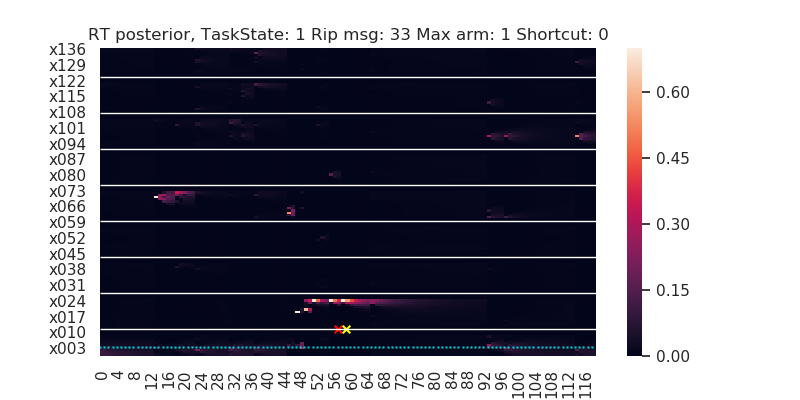

In [947]:
# plot posterior for all replays of arm 1 and arm 2
# include all replays, show taskState in title

# which files to use
stim_message_file = stim_message26
decoder_data_file = decoder_data26

for index, timestamp in enumerate(stim_message_file['bin_timestamp'][0:50]):
    if (stim_message_file[index:index+1]['posterior_max_arm'].values > 0 and 
        stim_message_file[index:index+1]['posterior_max_arm'].values < 3):
        posterior_to_plot = decoder_data_file[(decoder_data_file['bin_timestamp'] > timestamp-30*300) & 
                                            (decoder_data_file['bin_timestamp'] < timestamp+30*300)]
        posterior_to_plot = posterior_to_plot.reset_index()
        posterior_only_merged = posterior_to_plot.iloc[:,26:164]
        
        # start of ripple: lockout_message_joined: timestamp
        ripple_start = posterior_to_plot.index[(posterior_to_plot['bin_timestamp'].values >
                                               lockout_message_joined[index:index+1]['timestamp'].values) &
                                               (posterior_to_plot['bin_timestamp'].values <
                                               lockout_message_joined[index:index+1]['timestamp'].values+250)][0]
        # end of ripple: stim_message: bin_timestamp
        ripple_end = posterior_to_plot.index[posterior_to_plot['bin_timestamp'].values ==
                                             stim_message_file[index:index+1]['bin_timestamp'].values][0]

        # shortcut message arm
        max_arm = stim_message_file[index:index+1]['posterior_max_arm'].values[0]
        
        # shortcut message
        shortcut_message = stim_message_file[index:index+1]['shortcut_message_sent'].values[0]        

        # taskState
        taskState = stim_message_file[index:index+1]['taskState'].values[0]        

        #heatmap of posterior
        post_heatmap = posterior_only_merged.transpose()
        post_heatmap = post_heatmap.iloc[::-1]

        plt.figure(figsize=(8,4))
        plt.title(f'RT posterior, TaskState: {taskState} Rip msg: {index} Max arm: {max_arm} Shortcut: {shortcut_message}')
        ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        ##gap lines need to be inverse of where you would expect
        ax.hlines([136-11,136-27,136-43,136-59,136-75,136-91,136-107,136-123], lw=1, color='w',*ax.get_xlim())
        ax.scatter(np.arange(0,posterior_to_plot.shape[0]),136-posterior_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
        ## could take delay into account here: add delay/5
        ax.scatter(ripple_start,136-11,s=30,color='red',marker='x')
        ax.scatter(ripple_end,136-11,s=30,color='yellow',marker='x')

        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/remy_20_2_realtime_2_20_nonmatching_{ripple_num}_timestamp_{timestamp}.jpg')
        #plt.close()

In [1022]:
# check that stim message calculated the expected posterior sum

# real-time arm coords
arm_coords_test =  [[0,8],[13,24],[29,40],[45,56],[61,72],[77,88],[93,104],[109,120],[125,136]]

# message 0: post_time_bin = 33, bin_timestamp = 42285750
# for message 0: example_start_bin = 42285750 - (33*150) - (10*150) - (6*150)
# for message 0: example_end_bin = 42285750 - 7*150
# message 1: post_time_bin = 2, bin_timestamp = 43858800
# message 2: post_time_bin = 11, bin_timestamp = 43896600
# message 5: post_time_bin = 70, bin_timestamp = 45327450
# message 991: post_time_bin = 9, bin_timestamp = 162106350
# message 993: post_time_bin = 5, bin_timestamp = 162356850
# message 990: post_time_bin = 6, bin_timestamp = 162023250
# message 992: post_time_bin = 8, bin_timestamp = 162296550
# message 10: post_time_bin = 15, bin_timestamp = 45667350
# message 11: post_time_bin = 53, bin_timestamp = 45907950
# message 165: post_time_bin = 12, bin_timestamp = 66993150

# post sum sliding window is 11: this gives 10*150 timebins

# okay so it matches if you take off one bin from end - this is the 1 bin delay in the decoder, i think
# this worked for message 991, 993, 990
# try a few more at the top and in the middle 
# not sure why it fails (a little) for the first replay
# okay this is because of the velocity filter! figured it out
# anytime vel > 4, those bins don't go into the sum, they are skipped
# that is fine, that just comes with having a threshold

example_start_bin = 43896600 - (11*150) - (10*150)
example_end_bin = 43896600 - 150

posterior_to_sum = decoder_data26[(decoder_data26['bin_timestamp'] >= example_start_bin) & 
                                    (decoder_data26['bin_timestamp'] <= example_end_bin)]
posterior_to_sum

ripple_length = posterior_to_sum.shape[0]

post_sum_ripple = np.zeros((ripple_length,9))
for i in np.arange(0,ripple_length):
    if i == 0:
        for j in np.arange(0,len(arm_coords),1):
            post_sum_ripple[i,j] = posterior_to_sum.iloc[i,25:162].values[arm_coords_test[j][0]:arm_coords_test[j][1]+1].sum()
        #print(np.sum(post_sum_ripple[i,:]))
    else:
        for j in np.arange(0,len(arm_coords),1):
            post_sum_ripple[i,j] = post_sum_ripple[i-1,j] + posterior_to_sum.iloc[i,25:162].values[arm_coords_test[j][0]:arm_coords_test[j][1]+1].sum()
        #print(np.sum(post_sum_ripple[i,:]))
        
# normalize sum of whole ripple - this is the final row
# don't round too much here, set decimal to 4
post_sum_ripple[i] = post_sum_ripple[i]/post_sum_ripple[i].sum()
posterior_sum = np.around(post_sum_ripple[-1:],decimals=6)
posterior_sum = posterior_sum[0]
print('posterior:',posterior_sum,'sum:',np.sum(posterior_sum))
            


posterior: [0.824604 0.058316 0.010727 0.020717 0.014569 0.009582 0.030146 0.005714
 0.025623] sum: 0.999998


In [1019]:
stim_message26[0:10]
#42285750 - (32*150) - (10*150)
#posterior_to_sum

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,posterior_time_bin,delay,velocity,real_pos,spike_count,spike_count_base,taskState,posterior_max_arm,content_threshold,ripple_end,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,44683,42285750,42286175,42286220,1.589310e+09,0,2,33,15.666667,3.968014,4.0,113,2.06,1,0,0.5,0,1,0.914890,0.008872,0.011299,0.001998,0.004380,0.002232,0.006062,0.001998,0.048269
1,66751,43858800,43859340,43859400,1.589310e+09,0,3,2,20.000000,0.428445,0.0,2,2.06,1,0,0.5,0,1,0.599858,0.053490,0.052757,0.072179,0.035475,0.037852,0.040484,0.017954,0.089953
2,67394,43896600,43897120,43897200,1.589310e+09,0,4,11,20.000000,1.182151,0.0,44,2.06,1,0,0.5,0,1,0.824604,0.058316,0.010727,0.020717,0.014569,0.009582,0.030146,0.005714,0.025623
3,70287,44083800,44084143,44084200,1.589310e+09,0,5,11,13.333333,1.145416,3.0,19,2.06,1,0,0.5,0,1,0.651626,0.045399,0.075698,0.012688,0.011513,0.006681,0.165380,0.003543,0.027473
4,83602,44808450,44808982,44809100,1.589310e+09,0,7,6,21.666667,0.826010,0.0,12,2.06,1,0,0.5,0,1,0.917138,0.015458,0.013358,0.009664,0.010378,0.007974,0.008597,0.005775,0.011657
5,91693,45327450,45327929,45328060,1.589310e+09,0,9,70,20.333333,1.704413,0.0,436,2.06,1,0,0.5,0,1,0.545171,0.073479,0.069503,0.024876,0.072114,0.054517,0.036484,0.002440,0.121415
6,91828,45329850,45330387,45330640,1.589310e+09,0,10,7,26.333333,1.935251,0.0,23,2.06,1,99,0.5,0,1,0.359923,0.070269,0.136721,0.105333,0.048198,0.026286,0.020572,0.008368,0.224329
7,94528,45531750,45532127,45532200,1.589310e+09,0,11,11,15.000000,0.000000,0.0,73,2.06,1,99,0.5,0,1,0.417513,0.360045,0.084157,0.004058,0.013133,0.006857,0.048400,0.001353,0.064484
8,94861,45554700,45555380,45555440,1.589310e+09,0,12,5,24.666667,0.000000,0.0,8,2.06,1,0,0.5,0,1,0.781677,0.014998,0.012786,0.089320,0.009800,0.010265,0.028023,0.006526,0.046605
9,95999,45629700,45630270,45630360,1.589310e+09,0,13,7,22.000000,0.749141,0.0,13,2.06,1,0,0.5,0,1,0.845683,0.020839,0.014841,0.025217,0.015747,0.010601,0.014989,0.006746,0.045338


In [ ]:
lockout_message_joined[lockout_message_joined['rip_space']<200]
lockout_message_joined[(lockout_message_joined['lockout_num']>970) &
                       (lockout_message_joined['lockout_num']<977)]
stim_lockout17[stim_lockout17['big_rip_message_sent']==1]
lockout_message_joined[lockout_message_joined['spike_count_rip']==1]

In [ ]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)
rt_rips_to_check = stim_lockout17[stim_lockout17['lockout_state']==1]
rt_rips_to_check
#plt.figure(figsize=(5,3))
##plt.hist(stim_message1['ripple_time_bin'].values,bins=np.arange(0,100,5))
#plt.hist(rt_rips_to_check['timestamp'].diff()/30,bins=np.arange(0,500,10))


<IPython.core.display.Javascript object>


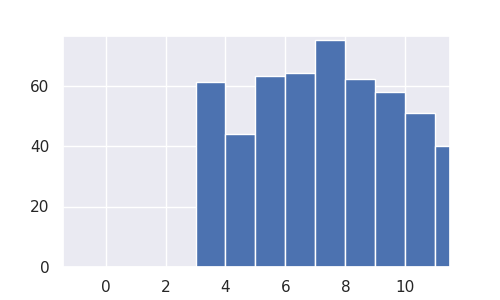

(array([ 0.,  0.,  0., 61., 44., 63., 64., 75., 62., 58., 51., 40., 32.,
        30., 28., 31., 27., 24., 25., 13., 13., 14., 15., 19., 22., 23.,
         6., 19., 14., 15., 10., 10., 14., 12., 16.,  8., 11.,  4.,  8.,
         5.,  6.,  3.,  3.,  5.,  4.,  2.,  7.,  2.,  7.,  2.,  4.,  5.,
         3.,  2.,  2.,  2.,  4.,  4.,  0.,  4.,  1.,  0.,  0.,  2.,  0.,
         3.,  1.,  0.,  1.,  0.,  3.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  4.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,

In [542]:
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 50)
stim_message15.shape
plt.figure(figsize=(5,3))
#plt.hist(stim_message1['ripple_time_bin'].values,bins=np.arange(0,100,5))
plt.hist(stim_message15['posterior_time_bin'].values,bins=np.arange(0,100))


In [436]:
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 50)


stim_lockout_file[stim_lockout_file['lockout_state']==1]
stim_message12
#lockout_message_joined['rip_space'] = (lockout_message_joined['timestamp'].diff())/30
print(lockout_message_joined[(lockout_message_joined['shortcut_message_sent']==1)].shape)

lockout_message_joined[(lockout_message_joined['rip_space']<300) & 
                       (lockout_message_joined['shortcut_message_sent']==1)].shape
#lockout_message_joined[(lockout_message_joined['rip_space']<300)].shape

(187, 34)


(29, 34)

In [ ]:
lockout_message_joined[(lockout_message_joined['shortcut_message_sent']==1)]['velocity_msg'].values

In [ ]:
# summary counts for real-time replay assignment - only works with later records that include real_pos
pd.set_option('display.max_rows', 12)
lockout_message_joined_count = lockout_message_joined.copy()
print(lockout_message_joined_count.shape)
lockout_message_joined_count = lockout_message_joined_count[lockout_message_joined_count['lockout_num']>0]
print(lockout_message_joined_count.shape)
lockout_message_joined_count = lockout_message_joined_count[lockout_message_joined_count['real_pos']<10]
print(lockout_message_joined_count.shape)

lockout_message_joined_count['posterior_max_arm'].value_counts()

In [ ]:
lockout_message_joined[(lockout_message_joined['posterior_max_arm']>0) &
                      (lockout_message_joined['posterior_max_arm']<10)]
lockout_message_joined[(lockout_message_joined['shortcut_message_sent']==1)]

In [196]:
# to make new dataframes for remy 21, 2 whole and partial encoding
#lockout_message_joined_whole = lockout_message_joined.copy()
lockout_message_joined_partial = lockout_message_joined.copy()

(188, 24)


<IPython.core.display.Javascript object>


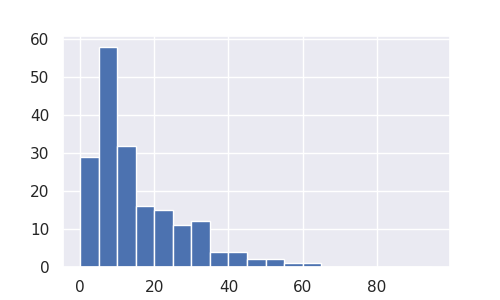

(array([29., 58., 32., 16., 15., 11., 12.,  4.,  4.,  2.,  2.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

In [73]:
# length of real-time ripples when a message was sent
stim_message1[stim_message1['velocity']>5]['ripple_time_bin'].values
realtime_messages_sent = stim_message1[(stim_message1['posterior_max_arm'].values>0) & 
                                       (stim_message1['posterior_max_arm'].values<10)]
print(realtime_messages_sent.shape)     

plt.figure(figsize=(5,3))
#plt.hist(stim_message1['ripple_time_bin'].values,bins=np.arange(0,100,5))
plt.hist(realtime_messages_sent['ripple_time_bin'].values,bins=np.arange(0,100,5))


In [854]:
# to match realtime and offline ripples
# NOTE: here we are using real-time as left dataframe and offline as right, reversed from cell above
# this seems to work better!!

#timestamp offset:
# remy day 20, epoch 2: 1958987
# gus day 17 epoch 3: 88254102
# remy day 21, epoch 2: 38,388,734

# choose files
stim_lockout_file = stim_lockout26

# original
#realtime_rips = stim_lockout_file[stim_lockout_file['lockout_state']==1]
# new: for real-time directly join lockout and message records
realtime_rips = lockout_message_joined.copy()
print('realtime rips',realtime_rips.shape)

offline_rips = rips.reset_index()
print('offline rips',offline_rips.shape)
offline_rips['adj_timestamp'] = offline_rips['timestamp']
#realtime_rips['adj_timestamp'] = realtime_rips['timestamp']+1958987-2100
# remove 70 msec adjustment for real-time ripples for better matching
realtime_rips['adj_timestamp'] = realtime_rips['timestamp']+1958987

realtime_rips
# merge real-time and offline ripples 
# offline ripple start is 50-100 msec before real-time
# try a tolerance of 300 msec = 9000 timestamps
# one problem is that we are only matching to the start of the offline ripple - but long ripples will get split in 2
# so we really want to match over the whole interval of the offline ripple
merged_ripple_times = pd.merge_asof(realtime_rips,offline_rips,on='adj_timestamp',tolerance=9000,direction='backward')
matching_offline_rips = merged_ripple_times[merged_ripple_times['lockout_num']>0]

# start delay for real-time rips compared to offline
matching_offline_rips['rt_delay'] = (((matching_offline_rips['timestamp_x']+1958987)-
                                     matching_offline_rips['timestamp_y'])/30)

# offline ripple duration
matching_offline_rips['off_dur'] = matching_offline_rips['endtime']-matching_offline_rips['starttime']

# note: still a few duplicates - this is coming from the original list of realtime ripples (stim_lockout)

# save mismatched ripples separately - these are real-time rips, so false positives
nonmatching_offline_rips = matching_offline_rips[matching_offline_rips['day'].isnull()]
# now need to remove ripples that dont match
matching_offline_rips = matching_offline_rips[matching_offline_rips['day']>0]

# 2 real-time rips match 1 offline rip
# note: there are about 40 of these - but some are actually two offline ripples not sure how to fix this
matching_offline_rips['two_RT_rips'] = matching_offline_rips['event'].diff()
print('2 RT match 1 offline',matching_offline_rips[matching_offline_rips['two_RT_rips']==0].shape)
# only keep rows where diff > 0 - this will remove double matches, specifically the second real-time rip
#matching_offline_rips = matching_offline_rips[matching_offline_rips['two_RT_rips']>0]

print('matching',matching_offline_rips.shape)

realtime rips (995, 36)
offline rips (1256, 7)
2 RT match 1 offline (6, 47)
matching (859, 47)


In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
stim_lockout20[stim_lockout20['lockout_state']<2][80:90]

In [858]:
# false positive real-time ripples aka dont match any offline ripple
# then pulled out the ones that send messages (18 or 225)
# can use these timestamps to check the offline decode during this time

# starttime should be timestamp_x
# endtime should be bin_timestamp

# note: should look at ripples where spike count is 0 or 1 at beginning of ripple
# these could be filtered out if we want

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
nonmatching_offline_rips
rt_msg_outside_rips = nonmatching_offline_rips[(nonmatching_offline_rips['real_pos']<10) & 
                       (nonmatching_offline_rips['posterior_max_arm']>0) &
                       (nonmatching_offline_rips['posterior_max_arm']<10)]
rt_msg_outside_rips_arm_sent = rt_msg_outside_rips['posterior_max_arm'].values
rt_msg_outside_rips_start = rt_msg_outside_rips['timestamp_x'].values
rt_msg_outside_rips_end = rt_msg_outside_rips['bin_timestamp'].values
rt_msg_outside_rips_spike = rt_msg_outside_rips['spike_count_rip'].values

print(nonmatching_offline_rips.shape)
print(rt_msg_outside_rips.shape)
print(rt_msg_outside_rips_spike)

(136, 46)
(17, 46)
[3 6 6 3 2 4 1 3 4 5 4 6 5 2 6 3 3]


In [716]:
pd.set_option('display.max_rows', 22)
pd.set_option('display.max_columns', 50)
rt_msg_outside_rips
# should be around 0:
# instead is centered around -10 msec - does that make sense?
(((rt_msg_outside_rips['lfp_timestamp']-rt_msg_outside_rips['timestamp_x']) - 
 ((5*rt_msg_outside_rips['posterior_time_bin']+rt_msg_outside_rips['delay'])*30))/30)
#(rt_msg_outside_rips['lfp_timestamp']-rt_msg_outside_rips['timestamp_x'])
#((5*rt_msg_outside_rips['posterior_time_bin']+rt_msg_outside_rips['delay'])*30)

32    -10.666667
53    -12.666667
59     -9.000000
82    -10.000000
194   -15.000000
242   -11.000000
315   -13.000000
362   -18.333333
442   -11.666667
611   -11.333333
684   -10.666667
807   -14.666667
840   -13.333333
875   -14.333333
881   -17.666667
888   -12.666667
955   -14.666667
964   -17.000000
974   -13.333333
dtype: float64

In [745]:
pd.set_option('display.max_rows', 105)
pd.set_option('display.max_columns', 50)
matching_offline_rips[(matching_offline_rips['real_pos']<10) & 
                       (matching_offline_rips['shortcut_message_sent']==1)]

,rec_ind_rip,timestamp_x,velocity_rip,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent,spike_count_rip,rec_ind_msg,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,posterior_time_bin,delay,velocity_msg,real_pos,spike_count_msg,spike_count_avg,posterior_max_arm,content_threshold,ripple_end,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,rip_space,adj_timestamp,day,epoch,event,timestamp_y,starttime,endtime,maxthresh,rt_delay,off_dur,two_RT_rips
33,170544,50713200,0.813387,41,1,6.0,0.0,2,170585,50713650,50714480,50714520,1.588980e+09,1,41,6,29.000000,0.873039,3.0,18,2.06,1,0.5,1,1,0.084271,0.580289,0.028200,0.016157,0.101894,0.077702,0.050599,0.023414,0.037474,6232.000000,52672187,20.0,2.0,159.0,52670624.0,1755.687467,1755.742800,2.263359,52.100000,0.055333,6.0
43,194515,52132720,0.535417,51,1,6.0,0.0,6,194723,52136400,52137060,52137140,1.588980e+09,1,51,27,24.666667,0.521184,3.0,84,2.06,4,0.5,1,1,0.247609,0.049522,0.017567,0.092536,0.543553,0.013167,0.013331,0.009041,0.013674,6836.000000,54091707,20.0,2.0,180.0,54089264.0,1802.975467,1803.106800,2.597699,81.433333,0.131333,3.0
46,196827,52278040,1.074857,54,1,6.0,0.0,6,196925,52280400,52280703,52280800,1.588980e+09,1,54,18,13.333333,1.411502,3.0,61,2.06,8,0.5,1,1,0.112020,0.010610,0.017320,0.005717,0.049008,0.015136,0.027903,0.012455,0.749830,1458.666667,54237027,20.0,2.0,184.0,54233584.0,1807.786133,1807.968133,2.334865,114.766667,0.182000,1.0
62,239057,54667280,1.508833,71,1,6.0,0.0,3,239189,54669150,54669753,54669800,1.588980e+09,1,71,15,21.666667,1.530040,3.0,45,2.06,8,0.5,1,1,0.160945,0.010208,0.011401,0.053299,0.071864,0.017490,0.069696,0.054182,0.550917,5056.666667,56626267,20.0,2.0,220.0,56623844.0,1887.461467,1887.628133,2.083809,80.766667,0.166667,2.0
72,257730,55748040,1.206054,81,1,6.0,0.0,9,257926,55751400,55751820,55751920,1.588980e+09,1,81,24,17.333333,1.039827,3.0,92,2.06,7,0.5,1,1,0.198000,0.021550,0.063843,0.019438,0.041386,0.013183,0.040649,0.566681,0.035269,7824.666667,57707027,20.0,2.0,236.0,57705144.0,1923.504800,1923.600800,4.718830,62.766667,0.096000,2.0
96,328429,59781820,1.797904,107,1,6.0,0.0,9,328583,59782500,59783300,59783320,1.588980e+09,1,107,7,27.333333,1.641427,3.0,29,2.06,1,0.5,1,1,0.002747,0.950865,0.002021,0.002035,0.004129,0.025738,0.004547,0.003437,0.004481,307.333333,61740807,20.0,2.0,312.0,61738724.0,2057.957467,2058.062133,5.806584,69.433333,0.104667,1.0
133,416642,64511320,0.991923,148,1,6.0,0.0,6,416840,64515300,64515675,64515760,1.588980e+09,1,148,29,15.333333,0.756399,3.0,98,2.06,6,0.5,1,1,0.065409,0.007150,0.008026,0.017866,0.029220,0.033930,0.687237,0.074655,0.076508,4031.333333,66470307,20.0,2.0,413.0,66467163.0,2215.572133,2215.742800,3.032796,104.800000,0.170667,1.0
168,460713,66991620,0.504113,185,1,6.0,0.0,2,460847,66993150,66993660,66993760,1.588980e+09,1,185,13,20.333333,0.397349,3.0,55,2.06,5,0.5,1,1,0.032669,0.015521,0.064636,0.014314,0.070392,0.621211,0.120231,0.038142,0.022884,2123.333333,68950607,20.0,2.0,474.0,68949544.0,2298.318133,2298.390800,3.688327,35.433333,0.072667,1.0
212,550526,72180180,2.623320,231,1,6.0,0.0,13,550624,72180900,72181320,72181460,1.588981e+09,1,231,7,18.666667,2.469159,3.0,26,2.06,6,0.5,1,1,0.106264,0.005871,0.006047,0.007674,0.024263,0.006308,0.639350,0.197973,0.006250,2119.333333,74139167,20.0,2.0,565.0,74136944.0,2471.231467,2471.354800,3.306598,74.100000,0.123333,1.0
231,596099,74534900,0.787927,252,1,6.0,0.0,1,596291,74538900,74539479,74538260,1.588981e+09,1,252,29,-21.333333,0.720641,3.0,84,2.06,3,0.5,1,1,0.064154,0.009692,0.096226,0.651514,0.088878,0.009073,0.048708,0.017858,0.013898,458.000000,76493887,20.0,2.0,628.0,76491644.0,2549.721467,2549.921467,2.118832,74.766667,0.200000,1.0


In [746]:
pd.set_option('display.max_rows', 22)
pd.set_option('display.max_columns', 50)
nonmatching_offline_rips[(nonmatching_offline_rips['real_pos']<10) & 
                       (nonmatching_offline_rips['shortcut_message_sent']==1)].shape
nonmatching_offline_rips.shape
rt_msg_outside_rips

,rec_ind_rip,timestamp_x,velocity_rip,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent,spike_count_rip,rec_ind_msg,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,posterior_time_bin,delay,velocity_msg,real_pos,spike_count_msg,spike_count_avg,posterior_max_arm,content_threshold,ripple_end,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,rip_space,adj_timestamp,day,epoch,event,timestamp_y,starttime,endtime,maxthresh,rt_delay,off_dur
35,171360,50775620,0.828057,43,1,6.0,0.0,3,171397,50776050,50776398,50776540,1.588980e+09,1,43,5,16.333333,0.947961,3.0,12,2.06,6,0.5,1,1,0.276104,0.021912,0.018657,0.020953,0.020562,0.040064,0.532977,0.038723,0.030046,1566.000000,52734607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,233812,54310580,2.013303,66,1,6.0,0.0,6,233901,54312300,54312680,54312820,1.588980e+09,1,66,14,17.333333,2.013303,3.0,46,2.06,8,0.5,1,1,0.070715,0.009850,0.007495,0.006080,0.164685,0.010038,0.009924,0.013678,0.707535,4412.666667,56269567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,240014,54710220,1.185599,73,1,6.0,0.0,3,240134,54713850,54714214,54714320,1.588980e+09,1,73,26,15.666667,0.932233,3.0,66,2.06,8,0.5,1,1,0.224988,0.011299,0.049474,0.008921,0.028803,0.013788,0.013355,0.031482,0.617890,891.333333,56669207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,304410,58471800,0.863259,99,1,6.0,0.0,0,304427,58471500,58472118,58472200,1.588980e+09,1,99,1,23.333333,0.863259,3.0,4,2.06,1,0.5,1,1,0.018422,0.819158,0.022827,0.018055,0.038814,0.027719,0.018718,0.017396,0.018889,531.333333,60430787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,529897,71050500,1.335746,220,1,6.0,0.0,2,529909,71050350,71050737,71050820,1.588981e+09,1,220,2,15.666667,1.335746,3.0,2,2.06,7,0.5,1,1,0.043226,0.040235,0.012688,0.009126,0.006185,0.014781,0.055253,0.804955,0.013549,484.666667,73009487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,630905,76442880,1.581507,271,1,6.0,0.0,4,630971,76443900,76444300,76444360,1.588981e+09,1,271,9,15.333333,1.274237,3.0,34,2.06,5,0.5,1,1,0.042014,0.008924,0.015095,0.013824,0.136269,0.645200,0.038770,0.088646,0.011258,3232.000000,78401867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,1191815,107910380,0.508918,566,1,6.0,0.0,5,1192023,107914350,107914980,107915060,1.588982e+09,1,566,29,23.666667,1.191598,3.0,99,2.06,5,0.5,1,1,0.185809,0.021212,0.078422,0.023396,0.025923,0.505561,0.023742,0.022660,0.113275,447.333333,109869367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,1382788,118506040,1.363688,668,1,6.0,0.0,2,1382826,118506450,118507240,118507280,1.588982e+09,1,668,5,27.666667,1.391714,3.0,9,2.06,6,0.5,1,1,0.030672,0.030371,0.023607,0.018311,0.019220,0.073282,0.765454,0.020942,0.018140,4941.333333,120465027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,1491569,124853340,1.744264,732,1,6.0,0.0,4,1491643,124855500,124855846,124855920,1.588982e+09,1,732,17,14.000000,1.656427,3.0,34,2.06,6,0.5,1,1,0.255179,0.024979,0.029617,0.015370,0.016032,0.031161,0.571210,0.028084,0.028370,780.000000,126812327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,1524773,126762020,3.813706,745,1,6.0,0.0,5,1524869,126767550,126767912,126767900,1.588982e+09,1,745,39,11.666667,2.650561,3.0,103,2.06,6,0.5,1,1,0.094969,0.091412,0.152511,0.020780,0.024376,0.038412,0.530767,0.016435,0.030338,21496.000000,128721007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


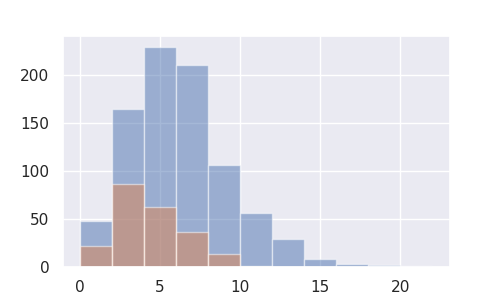

(221, 45)

In [608]:
# spike count in the bin at the time the ripple was detected
# blue is matching rips, red is non-matching
# so we can just through out ripples with small spike count in this bins - many true positives
plt.figure(figsize=(5,3))
plt.hist(matching_offline_rips['spike_count_rip'].values,bins=np.arange(0,24,2),alpha=0.5)
plt.hist(nonmatching_offline_rips['spike_count_rip'].values,bins=np.arange(0,24,2),alpha=0.5)

nonmatching_offline_rips.shape

<IPython.core.display.Javascript object>


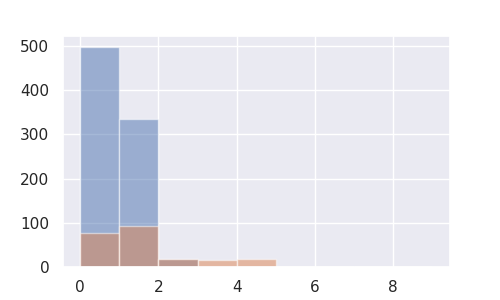

(221, 45)

In [612]:
# velocity when ripple was detected
# blue is matching rips, red is non-matching
# so we can just through out ripples with small spike count in this bins - many true positives
plt.figure(figsize=(5,3))
plt.hist(matching_offline_rips['velocity_rip'].values,bins=np.arange(0,10),alpha=0.5)
plt.hist(nonmatching_offline_rips['velocity_rip'].values,bins=np.arange(0,10),alpha=0.5)

nonmatching_offline_rips.shape

<IPython.core.display.Javascript object>


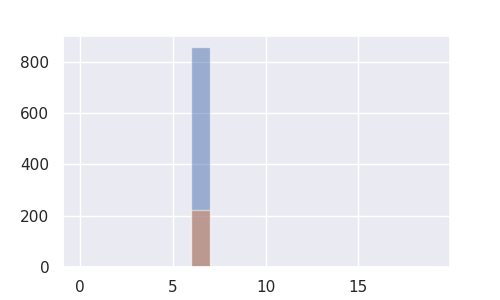

(221, 45)

In [614]:
# number tets above threshold when ripple was detected
# blue is matching rips, red is non-matching
# so we can just through out ripples with small spike count in this bins - many true positives
plt.figure(figsize=(5,3))
plt.hist(matching_offline_rips['tets_above_thresh'].values,bins=np.arange(0,20),alpha=0.5)
plt.hist(nonmatching_offline_rips['tets_above_thresh'].values,bins=np.arange(0,20),alpha=0.5)

nonmatching_offline_rips.shape

<IPython.core.display.Javascript object>


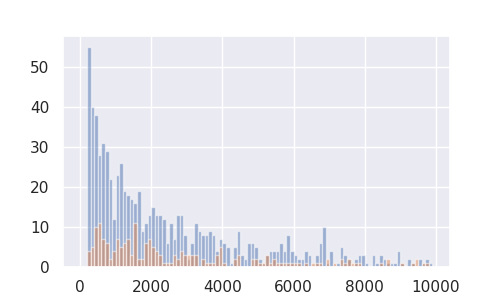

(221, 45)

In [617]:
# time between ripples
# blue is matching rips, red is non-matching
# so we can just through out ripples with small spike count in this bins - many true positives
plt.figure(figsize=(5,3))
plt.hist(matching_offline_rips['rip_space'].values,bins=np.arange(0,10000,100),alpha=0.5)
plt.hist(nonmatching_offline_rips['rip_space'].values,bins=np.arange(0,10000,100),alpha=0.5)

nonmatching_offline_rips.shape

In [ ]:
# plot of false positive ripples over time
# they seem to be even spread over the session

plt.figure(figsize=(10,4))

plt.scatter((matching_offline_rips['bin_timestamp'].values)/30000,np.repeat(3, 857),s=5)
plt.scatter((nonmatching_offline_rips['bin_timestamp'].values)/30000,np.repeat(2, 221),s=5)
plt.ylim(0,4)

In [409]:
# save out some different groups of ripples
#matching_300_double = matching_offline_rips[matching_offline_rips['two_RT_rips']==0]
#matching_300_all = matching_offline_rips.copy()
#matching_300_150plus = matching_offline_rips[matching_offline_rips['rt_delay']>150]
matching_200_double = matching_offline_rips[matching_offline_rips['two_RT_rips']==0]
matching_200_all = matching_offline_rips.copy()
matching_200_150plus = matching_offline_rips[matching_offline_rips['rt_delay']>150]

<IPython.core.display.Javascript object>


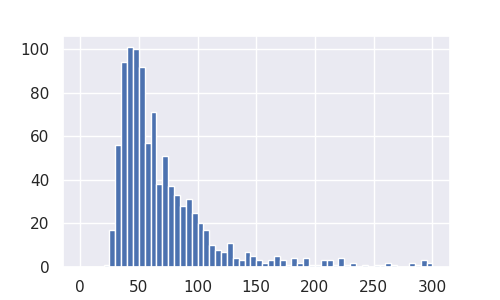

(array([  0.,   0.,   0.,   0.,   1.,  17.,  56.,  94., 101., 100.,  92.,
         57.,  71.,  38.,  51.,  37.,  33.,  28.,  31.,  25.,  20.,  17.,
         10.,   8.,   7.,  11.,   4.,   3.,   7.,   5.,   3.,   2.,   3.,
          5.,   3.,   1.,   4.,   2.,   4.,   1.,   1.,   3.,   3.,   1.,
          4.,   1.,   2.,   0.,   1.,   0.,   1.,   1.,   2.,   1.,   0.,
          0.,   2.,   1.,   3.,   2.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
        260, 265, 270, 275, 280, 285, 290, 295, 300]),
 <a list of 60 Patch objects>)

In [399]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
matching_offline_rips[matching_offline_rips['two_RT_rips']==0]
plt.figure(figsize=(5,3))
plt.hist(matching_offline_rips['rt_delay'].values,bins=np.arange(0,305,5))


In [415]:
matching_200_150plus.shape

(28, 44)

<IPython.core.display.Javascript object>


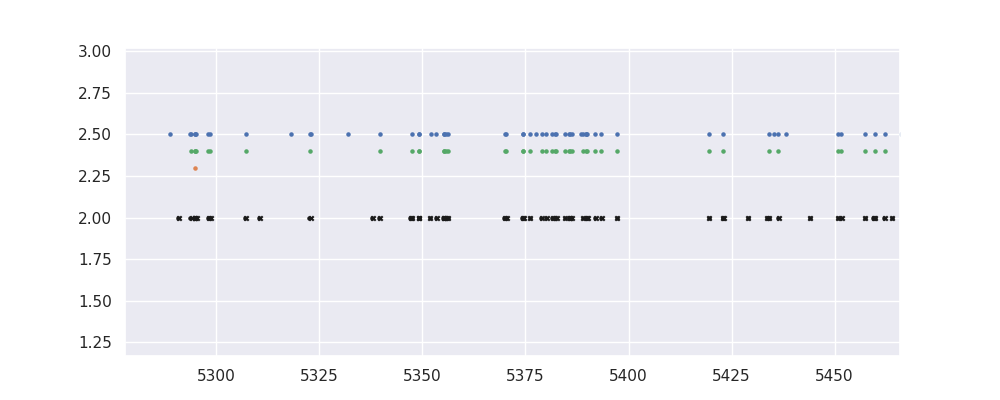

(1, 3)

In [416]:
# okay so the idea is that very long delays between real-time and offline ripple start
# is actually a problem with my matching afterwards
# need to make the ripple scatter plot with true positives and false positives where delay is greater than 125 msec

off_rips_range = rips.copy()
off_rips_range['end_timestamp'] = off_rips_range['timestamp'] + ((off_rips_range['endtime'] - off_rips_range['starttime'])*30000)
off_rips_range

stim_lockout_file = stim_lockout12
realtime_rips_plot = stim_lockout_file[stim_lockout_file['lockout_state']==1]

plt.figure(figsize=(10,4))
plt.scatter(off_rips_range['timestamp'].values/30000,np.repeat(2, 1256),s=5,c='k')
plt.scatter(off_rips_range['end_timestamp'].values/30000,np.repeat(2, 1256),s=10,c='k',marker='x')
plt.scatter((realtime_rips_plot['timestamp'].values+1958987)/30000,np.repeat(2.5, 1245),s=5)
plt.scatter((matching_200_double['adj_timestamp'].values)/30000,np.repeat(2.3, 22),s=5)
plt.scatter((matching_200_all['adj_timestamp'].values)/30000,np.repeat(2.4, 952),s=5)
plt.scatter((matching_200_150plus['adj_timestamp'].values)/30000,np.repeat(2.2, 28),s=5)

#plt.scatter((rt_all_positives_rip['adj_timestamp'].values)/30000,np.repeat(2.3, 141),s=5)

#plt.scatter((ripple_delay_FP['adj_timestamp'].values)/30000,np.repeat(2.2, 42),s=5)

plt.ylim([1,3])

<IPython.core.display.Javascript object>


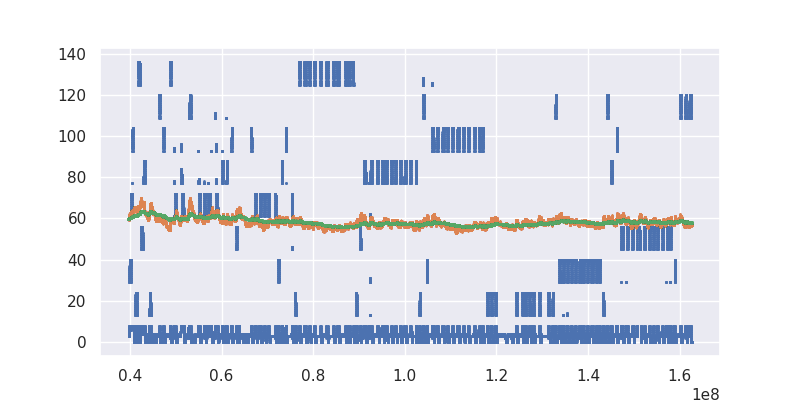

In [254]:
# track LFP mean across session
tet_30_LFP = ripple_data6[ripple_data6['elec_grp_id']==30]
tet_31_LFP = ripple_data5[ripple_data5['elec_grp_id']==30]

plt.figure(figsize=(8,4))
plt.scatter(occupancy_data5['bin_timestamp'].values,occupancy_data5['linear_pos'].values,s=1)
plt.scatter(tet_31_LFP['timestamp'].values,(tet_31_LFP['custom_mean'].values*5),s=.02)
plt.scatter(tet_30_LFP['timestamp'].values,tet_30_LFP['custom_mean'].values*5,s=.1)


#plt.scatter(stim_message6['bin_timestamp'].values,stim_message6['spike_count_avg'].values*10,s=3)


<IPython.core.display.Javascript object>


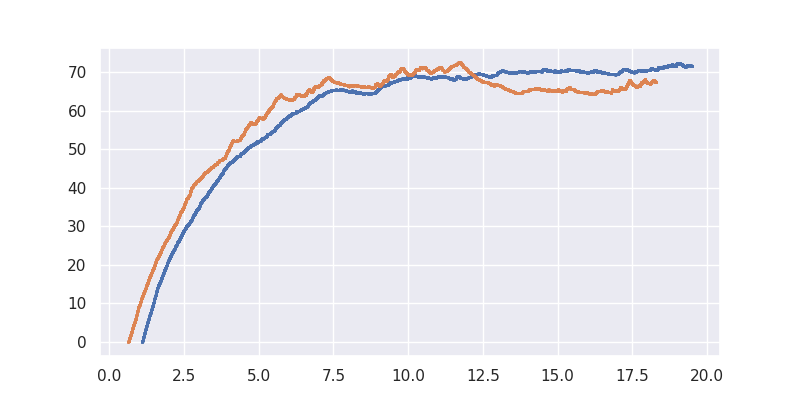

In [263]:
# remy 20 sleep session 1: track LFP mean across session
tet_30_LFP = ripple_data8[ripple_data8['elec_grp_id']==30]
tet_31_LFP = ripple_data7[ripple_data7['elec_grp_id']==30]

plt.figure(figsize=(8,4))
#plt.scatter(occupancy_data5['bin_timestamp'].values,occupancy_data5['linear_pos'].values,s=1)
plt.scatter(tet_30_LFP['timestamp'].values/30000/60,tet_30_LFP['custom_mean'].values*5,s=.1)
plt.scatter(tet_31_LFP['timestamp'].values/30000/60,tet_31_LFP['custom_mean'].values*5,s=.1)


In [ ]:
# plot realtime and offline ripple starts
#matching_offline_rips_3k = matching_offline_rips.copy()
#matching_offline_rips_3k_fwd = matching_offline_rips.copy()
#matching_offline_rips_9k_fwd = matching_offline_rips.copy()

off_rips_range = rips.copy()
off_rips_range['end_timestamp'] = off_rips_range['timestamp'] + ((off_rips_range['endtime'] - off_rips_range['starttime'])*30000)
off_rips_range

stim_lockout_file = stim_lockout5
realtime_rips_plot = stim_lockout_file[stim_lockout_file['lockout_state']==1]

plt.figure(figsize=(10,4))
plt.scatter(off_rips_range['timestamp'].values/30000,np.repeat(2, 1256),s=5,c='k')
plt.scatter(off_rips_range['end_timestamp'].values/30000,np.repeat(2, 1256),s=10,c='k',marker='x')
plt.scatter((realtime_rips_plot['timestamp'].values+1958987)/30000,np.repeat(2.5, 3561),s=5)
#plt.scatter((matching_offline_rips_3k['adj_timestamp'].values)/30000,np.repeat(2.45, 547),s=5)
#plt.scatter((matching_offline_rips_3k_fwd['adj_timestamp'].values)/30000,np.repeat(2.4, 408),s=5)
#plt.scatter((matching_offline_rips_9k_fwd['adj_timestamp'].values)/30000,np.repeat(2.35, 547),s=5)
plt.scatter((matching_offline_rips['adj_timestamp'].values)/30000,np.repeat(2.3, 3061),s=5)

plt.ylim([1,3])

In [859]:
# running sum version for offline ripples - 50 msec running sum means 11 bins
# offline posteriors, 150 uV threshold
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
# old linearization
#arm_coords = [[0,8],[13,25],[30,42],[47,59],[65,77],[82,94],[99,111],[116,128],[133,145]]
# new linearization
arm_coords = [[0,8],[13,25],[29,41],[45,57],[62,74],[78,90],[94,106],[111,123],[127,139]]

# max value for other outer arm
other_arm_thresh = 0.2

#posterior sum threshold for primary arm
post_sum_thresh = 0.5

# if we want to check all offline ripples
offline_rips_plot = rips.copy()
offline_rips_plot = offline_rips_plot.reset_index()

summarize_all_rips_offline = True

# now need to plot offline ripples that are mismatched

# set which posteriors file to use
posterior_offline = posteriors.reset_index()
offline_pos = binned_linear_pos.reset_index()
merged_off_post_pos = pd.merge_asof(posterior_offline,offline_pos,on='timestamp',direction='nearest')
#offline_posterior_sum_all = np.zeros((len(matching_offline_rips),14))
# for all offline rips
offline_posterior_sum_all = np.zeros((len(offline_rips_plot),15))

# number of bins for sliding window sum
sliding_window = 11

# length for whole ripple sum: all rips longer than this (previously 12, set to 115 to cover all ripples)
whole_ripple_sum_len = 115

# updated for new matching_offline_rips merge timestamp_x -> timestamp_y
# for some reason, final offline rip timestamp is after the decoder has ended - odd
# to deal with this set slice to [:-1]
for index, rip_timestamp in enumerate(matching_offline_rips['timestamp_y'][:-1]):

# ripple range: Remy day 20, epoch 2 18:-1
# ripple range: Remy day 20, epoch 4 20:-4

# to plot all offline rips
#for index, rip_timestamp in enumerate(offline_rips_plot['timestamp'][18:-1]):
    posterior_sum_array = np.zeros((sliding_window,9))
    short_ripple = False
    # to plot all ripples
    if summarize_all_rips_offline:
    # to plotting mis-match replays
    #if matching_offline_rips['lockout_num'][index:index+1].values in non_matching['realtime_rip'].values:
        #print(matching_offline_rips['lockout_num'][index:index+1].values)
        #print(rip_timestamp-30*300,rip_timestamp+30*300,index)
        
        posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > rip_timestamp-30*300) & 
                                            (merged_off_post_pos['timestamp'] < rip_timestamp+30*300)]

        # original: real-time data
        realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
        # for plotting offline rips only
        #realtime_ripple_num = 1
        
        ripple_num_index = int(len(posterior_to_plot)*0.55)
        ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values
        real_pos = posterior_to_plot[ripple_num_index:ripple_num_index+1]['linpos_flat'].values
    
        # calculate posterior sum during ripple
        # we need to only take out the time when ripple_grp matches ripple_grp at the middle of the plotting bin
    
        #post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]
        post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] == ripple_num[0]]
        ripple_length = post_sum_times.shape[0]
        #if ripple_length < 12:
        #    print(index,ripple_length)
        
        # if ripple is less than 12 bins: sum whole ripple
        # added 1 to end of each segment - makes sum across arms correct
        if ripple_length < whole_ripple_sum_len:
            # sum each arm over whole ripple
            post_sum_ripple = np.zeros((ripple_length,9))
            for i in np.arange(0,ripple_length):
                if i == 0:
                    for j in np.arange(0,len(arm_coords),1):
                        post_sum_ripple[i,j] = post_sum_times.iloc[i,4:145].values[arm_coords[j][0]:arm_coords[j][1]+1].sum()
                else:
                    for j in np.arange(0,len(arm_coords),1):
                        post_sum_ripple[i,j] = post_sum_ripple[i-1,j] + post_sum_times.iloc[i,4:145].values[arm_coords[j][0]:arm_coords[j][1]+1].sum()
            
            # normalize sum of whole ripple - this is the final row
            # need to change decimal to 4 here!
            short_ripple = True
            post_sum_ripple[i] = post_sum_ripple[i]/post_sum_ripple[i].sum()
            posterior_sum = np.around(post_sum_ripple[-1:],decimals=4)
            posterior_sum = posterior_sum[0]
    
            # new version
            # other arm: make this a settable paramater (e.g. 0.2 or 0.1)
            # new code to remove manual check for each arm - working
            if len(np.argwhere(posterior_sum>=post_sum_thresh)) and np.argwhere(posterior_sum>=post_sum_thresh)[0][0] == 0:
                arm_max = 0
            elif len(np.argwhere(posterior_sum>=post_sum_thresh)):
                posterior_sum_arms = posterior_sum[1:]
                arm_max = np.argwhere(posterior_sum_arms>=post_sum_thresh)[0][0] + 1
                other_arms_sum = np.delete(posterior_sum_arms, arm_max - 1)
                if len(np.argwhere(other_arms_sum>=other_arm_thresh)):
                    #print('other_arm')
                    arm_max = 98
            else:
                arm_max = 99
                
        # if ripple 12 or more bins: use sliding window sum
        else:
            print('long_ripple',ripple_length)
            stop_post_sum = False
            post_sum_ripple = np.zeros((ripple_length,9))
            for i in np.arange(0,ripple_length):
                # first sum across arms
                for j in np.arange(0,len(arm_coords),1):
                    post_sum_ripple[i,j] = post_sum_times.iloc[i,4:145].values[arm_coords[j][0]:arm_coords[j][1]+1].sum()
                # then fill in sliding window array
                posterior_sum_array[np.mod(i,sliding_window),:] = post_sum_ripple[i]
                sum_array_sum = np.sum(posterior_sum_array,axis=0)
                norm_posterior_arm_sum = sum_array_sum/sliding_window
                if i > 10 and not stop_post_sum:
                    posterior_sum = np.around(norm_posterior_arm_sum,decimals=4)
                    #print(posterior_sum)
                    #posterior_sum = posterior_sum[0]
                    if len(np.argwhere(posterior_sum>=0.5)):
                        arm_max = np.argwhere(posterior_sum>=0.5)[0][0]
                    else:
                        arm_max = 99
                    if arm_max > 0 and arm_max < 9:
                        stop_post_sum = True
                        #print('post sum meets criteria. bin',i,'arm',arm_max)
        
        ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

        #posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
        #                                         'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
        #                                         'linvel_flat'], axis=1)
        posterior_offline1 = posterior_to_plot.iloc[:,4:145]

        posterior_offline2 = posterior_offline1.fillna(0)
        post_heatmap = posterior_offline2.transpose()
        post_heatmap = post_heatmap.iloc[::-1]

        #posterior_sum = np.around(post_sum_ripple[-1:],decimals=1)
        #posterior_sum = posterior_sum[0]
    
        #if len(np.argwhere(posterior_sum>=0.5)):
        #    arm_max = np.argwhere(posterior_sum>=0.5)[0][0]
        #else:
        #    arm_max = 99 

        # fill in current row of posterior sum array - seems to work
        offline_posterior_sum_all[index,0] = ripple_num
        offline_posterior_sum_all[index,1] = realtime_ripple_num
        offline_posterior_sum_all[index,2] = arm_max
        offline_posterior_sum_all[index,3] = posterior_sum[0]
        offline_posterior_sum_all[index,4] = posterior_sum[1]
        offline_posterior_sum_all[index,5] = posterior_sum[2]
        offline_posterior_sum_all[index,6] = posterior_sum[3]
        offline_posterior_sum_all[index,7] = posterior_sum[4]
        offline_posterior_sum_all[index,8] = posterior_sum[5]
        offline_posterior_sum_all[index,9] = posterior_sum[6]
        offline_posterior_sum_all[index,10] = posterior_sum[7]
        offline_posterior_sum_all[index,11] = posterior_sum[8]
        offline_posterior_sum_all[index,12] = ripple_length
        offline_posterior_sum_all[index,13] = short_ripple
        offline_posterior_sum_all[index,14] = real_pos
                                     
        #plt.figure(figsize=(8,4))
        #plt.title(f'Off rip {ripple_num}. RT rip {realtime_ripple_num} Arm {arm_max} {posterior_sum} Len {ripple_length}')
        #ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        #ax.hlines([139-10,139-27,139-43,139-59,139-76,139-92,139-108,139-125], lw=2, color='w',*ax.get_xlim())
        #ax.scatter(np.arange(0,posterior_to_plot.shape[0]),139-posterior_to_plot['linpos_flat'].values,s=2,alpha=1,color='cyan')
        #ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.25,*ax.get_ylim())
    
        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/remy_20_2_offline_2_20_rip_nonmatching_{ripple_num}_real_rip_{realtime_ripple_num}_timestamp_{rip_timestamp}.jpg')

# convert offline_posterior_sum_all array to pandas
# only run this first time through - not with non-matching

off_post_sum_summary = pd.DataFrame(data=offline_posterior_sum_all,columns=('offline_rip','realtime_rip',
                                                                            'off_max_arm','box','arm1','arm2',
                                                                            'arm3','arm4','arm5','arm6',
                                                                            'arm7','arm8',
                                                                            'rip_length','short_rip','real_pos'))

off_post_sum_summary.shape

(1256, 15)

In [792]:
# summary counts for replay assignment
pd.set_option('display.max_rows', 12)
off_post_sum_summary_count = off_post_sum_summary.copy()
off_post_sum_summary_count = off_post_sum_summary_count[off_post_sum_summary_count['offline_rip']>0]
off_post_sum_summary_count = off_post_sum_summary_count[off_post_sum_summary_count['real_pos']<10]
print(off_post_sum_summary_count.shape)
off_post_sum_summary_count
off_post_sum_summary_count['off_max_arm'].value_counts()

(1142, 15)


0.0     877
98.0     60
1.0      47
5.0      38
99.0     27
6.0      24
8.0      22
7.0      15
2.0      12
3.0      12
4.0       8
Name: off_max_arm, dtype: int64

In [ ]:
# join offline and realtime replay summaries
# how to identify ripples that were too long, and there is no replay assignment?

# remove ripples past end of offline decoding (b/c of trial time filter?)
#off_post_sum_summary = off_post_sum_summary[off_post_sum_summary['offline_rip']>0]

replay_summary_combined = pd.DataFrame.join(off_post_sum_summary,realtime_post_sum_summary,on='realtime_rip',
                                            how='outer',lsuffix='off',rsuffix='rt')
replay_combined_matching = replay_summary_combined[replay_summary_combined['offline_rip']>0]
print(replay_combined_matching.shape)
# remove ripples in outer arms
replay_combined_matching = replay_combined_matching[replay_combined_matching['real_posrt']<10]
print(replay_combined_matching.shape)

# what is this plot showing???? - showing duplicate real-time rips (0 bin in histogram)
plt.figure(figsize=(5,3))
plt.hist(replay_combined_matching['realtime_rip'].diff(),bins=np.arange(0,10))

(858, 51)
(856, 51)
(810, 51)


<IPython.core.display.Javascript object>


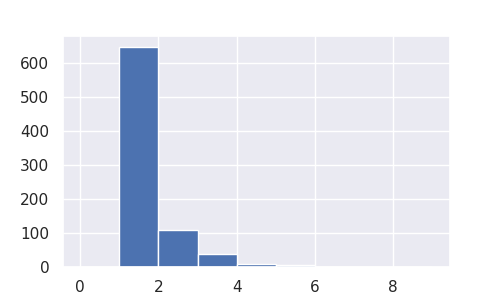

(array([  0., 648., 108.,  38.,   9.,   5.,   0.,   1.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

In [860]:
# try join with new ripple/replay join

off_post_sum_summary_filt = off_post_sum_summary[off_post_sum_summary['realtime_rip']>0]
realtime_post_sum_summary = lockout_message_joined.copy()

# original
#replay_summary_combined = pd.DataFrame.join(off_post_sum_summary,realtime_post_sum_summary,on='realtime_rip',
#                                            how='outer',lsuffix='off',rsuffix='rt')
# new
replay_summary_combined = pd.DataFrame.merge(off_post_sum_summary_filt,realtime_post_sum_summary,how='inner',
                                            left_on='realtime_rip',right_on='lockout_num',
                                             suffixes=('_off', '_rt'))
print(replay_summary_combined.shape)

replay_combined_matching = replay_summary_combined[replay_summary_combined['offline_rip']>0]
print(replay_combined_matching.shape)

# remove ripples in outer arms
# old message record
#replay_combined_matching = replay_combined_matching[replay_combined_matching['real_pos']<10]

# new message record
replay_combined_matching = replay_combined_matching[replay_combined_matching['real_pos_rt']<10]
print(replay_combined_matching.shape)

# plot shows duplicate real-time rips (0 bin in histogram)
plt.figure(figsize=(5,3))
plt.hist(replay_combined_matching['realtime_rip'].diff(),bins=np.arange(0,10))

In [313]:
# replay arm counts for real-time
replay_combined_matching['posterior_max_arm'].value_counts()

0     540
99    461
6      42
1      40
5      19
98     14
4       7
3       7
7       5
8       4
2       4
Name: posterior_max_arm, dtype: int64

In [214]:
# join for two real-time runs
# realtime_post_sum_summary_whole and realtime_post_sum_summary_partial

#off_post_sum_summary_filt = off_post_sum_summary[off_post_sum_summary['realtime_rip']>0]
realtime_post_sum_summary_whole = lockout_message_joined_whole.copy()
realtime_post_sum_summary_partial = lockout_message_joined_partial.copy()

# original
#replay_summary_combined = pd.DataFrame.join(off_post_sum_summary,realtime_post_sum_summary,on='realtime_rip',
#                                            how='outer',lsuffix='off',rsuffix='rt')
# new
replay_summary_combined = pd.DataFrame.merge(realtime_post_sum_summary_whole,realtime_post_sum_summary_partial,
                                             how='inner',left_on='timestamp',right_on='timestamp',
                                             suffixes=('_whole', '_part'))
print(replay_summary_combined.shape)

# rename replay assignment columns to matched expected
replay_summary_combined.rename(columns={"posterior_max_arm_whole": "off_max_arm", 
                                        "posterior_max_arm_part": "posterior_max_arm"},inplace=True)

replay_combined_matching = replay_summary_combined[replay_summary_combined['lockout_num_whole']>0]
print(replay_combined_matching.shape)

# remove ripples in outer arms
#replay_combined_matching = replay_combined_matching[replay_combined_matching['real_pos']<10]
#print(replay_combined_matching.shape)

(1514, 61)
(1514, 61)


In [861]:
# replay matching for real-time and offline decoder of offline ripple times
# summary for new combined dataframe with lockout/replay table

# re-run without dealy
# re-run with delay and full session

# make histogram of classification for all replays

#summarize matching between offline and realtime
print('total ripples:',replay_combined_matching.shape[0])

#exact match
matching_replays = (replay_combined_matching[replay_combined_matching['off_max_arm'].values == 
                                              replay_combined_matching['posterior_max_arm'].values])

print('exact match:',matching_replays.shape[0])
# non-matching
non_matching = replay_combined_matching[replay_combined_matching['off_max_arm'].values != 
                                       replay_combined_matching['posterior_max_arm'].values]
print('non-matching:',non_matching.shape[0])

# count for each arm in realtime replays
print('realtime below 0.5:',non_matching[non_matching['posterior_max_arm'] == 99].shape[0])
print('realtime box:',non_matching[non_matching['posterior_max_arm'] == 0].shape[0])
print('realtime arm 1:',non_matching[non_matching['posterior_max_arm'] == 1].shape[0])
print('realtime arm 2:',non_matching[non_matching['posterior_max_arm'] == 2].shape[0])
print('realtime arm 3:',non_matching[non_matching['posterior_max_arm'] == 3].shape[0])
print('realtime arm 4:',non_matching[non_matching['posterior_max_arm'] == 4].shape[0])
print('realtime arm 5:',non_matching[non_matching['posterior_max_arm'] == 5].shape[0])
print('realtime arm 6:',non_matching[non_matching['posterior_max_arm'] == 6].shape[0])
print('realtime arm 7:',non_matching[non_matching['posterior_max_arm'] == 7].shape[0])
print('realtime arm 8:',non_matching[non_matching['posterior_max_arm'] == 8].shape[0])
print('realtime no arm:',non_matching[non_matching['posterior_max_arm'] == 98].shape[0])

# offline: no arm above 0.5
mismatch_05_total = non_matching[non_matching['off_max_arm'] == 99]
mismatch_05_rt_box = non_matching[(non_matching['off_max_arm'] == 99) & 
                                  (non_matching['posterior_max_arm'] == 0)]
mismatch_05_rt_other = non_matching[(non_matching['off_max_arm'] == 99) & 
                                  (non_matching['posterior_max_arm'] == 98)]
mismatch_05_rt_arm = non_matching[(non_matching['off_max_arm'] == 99) & 
                                  (non_matching['posterior_max_arm'] > 0) &
                                  (non_matching['posterior_max_arm'] < 10)]
print('offline < 0.5, mismatch total:',mismatch_05_total.shape[0])
print('offline < 0.5, realtime box:',mismatch_05_rt_box.shape[0])
print('offline < 0.5, realtime arm:',mismatch_05_rt_arm.shape[0])
print('offline < 0.5, realtime other arm:',mismatch_05_rt_other.shape[0])

# offline: box
mismatch_box_total = non_matching[non_matching['off_max_arm'] == 0]
mismatch_box_rt_05 = non_matching[(non_matching['off_max_arm'] == 0) & 
                                  (non_matching['posterior_max_arm'] == 99)]
mismatch_box_rt_other = non_matching[(non_matching['off_max_arm'] == 0) & 
                                  (non_matching['posterior_max_arm'] == 98)]
mismatch_box_rt_arm = non_matching[(non_matching['off_max_arm'] == 0) & 
                                   (non_matching['posterior_max_arm'] > 0) &
                                   (non_matching['posterior_max_arm'] < 10)]
print('offline box, mismatch total:',mismatch_box_total.shape[0])
print('offline box, realtime < 0.5:',mismatch_box_rt_05.shape[0])
print('offline box, realtime arm:',mismatch_box_rt_arm.shape[0])
print('offline box, realtime other arm:',mismatch_box_rt_other.shape[0])

# offline: outer arm
mismatch_arm_total = non_matching[(non_matching['off_max_arm'] > 0)&
                                  (non_matching['off_max_arm'] < 10)]
mismatch_arm_rt_05 = non_matching[(non_matching['off_max_arm'] > 0)&
                                  (non_matching['off_max_arm'] < 10) & 
                                  (non_matching['posterior_max_arm'] == 99)]
mismatch_arm_rt_box = non_matching[(non_matching['off_max_arm'] > 0)&
                                   (non_matching['off_max_arm'] < 10) & 
                                   (non_matching['posterior_max_arm'] == 0)]
mismatch_arm_rt_other = non_matching[(non_matching['off_max_arm'] > 0)&
                                  (non_matching['off_max_arm'] < 10) & 
                                  (non_matching['posterior_max_arm'] == 98)]
mismatch_arm_rt_arm = non_matching[(non_matching['off_max_arm'] > 0)&
                                   (non_matching['off_max_arm'] < 10) & 
                                   (non_matching['posterior_max_arm'] > 0) &
                                   (non_matching['posterior_max_arm'] < 10)]
print('offline arm, mismatch total:',mismatch_arm_total.shape[0])
print('offline arm, realtime < 0.5:',mismatch_arm_rt_05.shape[0])
print('offline arm, realtime box:',mismatch_arm_rt_box.shape[0])
print('offline arm, realtime arm:',mismatch_arm_rt_arm.shape[0])
print('offline arm, realtime other arm:',mismatch_arm_rt_other.shape[0])

#offline: other outer arm filter
mismatch_other_total = non_matching[non_matching['off_max_arm'] == 98]
mismatch_other_rt_box = non_matching[(non_matching['off_max_arm'] == 98) & 
                                  (non_matching['posterior_max_arm'] == 0)]
mismatch_other_rt_05 = non_matching[(non_matching['off_max_arm'] == 98) & 
                                  (non_matching['posterior_max_arm'] == 99)]
mismatch_other_rt_arm = non_matching[(non_matching['off_max_arm'] == 98) & 
                                  (non_matching['posterior_max_arm'] > 0) &
                                  (non_matching['posterior_max_arm'] < 10)]
print('offline other arm filter, mismatch total:',mismatch_other_total.shape[0])
print('offline other arm filter, realtime box:',mismatch_other_rt_box.shape[0])
print('offline other arm filter, realtime 0.5:',mismatch_other_rt_05.shape[0])
print('offline other arm filter, realtime arm:',mismatch_other_rt_arm.shape[0])


print('exact match fraction',np.around((matching_replays.shape[0]/replay_combined_matching.shape[0]),decimals=2))

print('same message fraction',np.around((matching_replays.shape[0]+mismatch_05_rt_box.shape[0]+
                                         mismatch_box_rt_05.shape[0]+mismatch_other_rt_box.shape[0]+
                                         mismatch_other_rt_05.shape[0])/replay_combined_matching.shape[0],decimals=2))

print('false negative',np.around((mismatch_arm_rt_05.shape[0]+mismatch_arm_rt_box.shape[0]+
                                 mismatch_arm_rt_other.shape[0])/replay_combined_matching.shape[0],decimals=2))

false_positive_data = pd.concat([mismatch_05_rt_arm, mismatch_box_rt_arm, mismatch_arm_rt_arm,mismatch_other_rt_arm])

print('false positive count',false_positive_data.shape[0])

replay_false_positive = (mismatch_05_rt_arm.shape[0]+mismatch_box_rt_arm.shape[0]+
                         mismatch_arm_rt_arm.shape[0]+mismatch_other_rt_arm.shape[0])

print('false positive',np.around(replay_false_positive/replay_combined_matching.shape[0],decimals=2))

# false positives of sent messages
all_sent_message = replay_combined_matching[(replay_combined_matching['posterior_max_arm'] > 0) & 
                                           (replay_combined_matching['posterior_max_arm'] < 10)]
print('false positive messages:',np.around(replay_false_positive/all_sent_message.shape[0],decimals=2))

total ripples: 810
exact match: 599
non-matching: 211
realtime below 0.5: 129
realtime box: 48
realtime arm 1: 3
realtime arm 2: 6
realtime arm 3: 1
realtime arm 4: 0
realtime arm 5: 2
realtime arm 6: 6
realtime arm 7: 2
realtime arm 8: 6
realtime no arm: 8
offline < 0.5, mismatch total: 71
offline < 0.5, realtime box: 45
offline < 0.5, realtime arm: 21
offline < 0.5, realtime other arm: 5
offline box, mismatch total: 90
offline box, realtime < 0.5: 88
offline box, realtime arm: 2
offline box, realtime other arm: 0
offline arm, mismatch total: 44
offline arm, realtime < 0.5: 38
offline arm, realtime box: 3
offline arm, realtime arm: 0
offline arm, realtime other arm: 3
offline other arm filter, mismatch total: 6
offline other arm filter, realtime box: 0
offline other arm filter, realtime 0.5: 3
offline other arm filter, realtime arm: 3
exact match fraction 0.74
same message fraction 0.91
false negative 0.05
false positive count 26
false positive 0.03
false positive messages: 0.28


In [864]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
print(false_positive_data.shape)
print(matching_replays[(matching_replays['posterior_max_arm']>0) &
                      (matching_replays['posterior_max_arm']<10)].shape)
print(false_positive_data['spike_count_rip'].values)
matching_replays[(matching_replays['posterior_max_arm']>0) &
                (matching_replays['posterior_max_arm']<10)]['spike_count_rip'].values
#false_positive_data

(26, 51)
(68, 51)
[ 3  9  3  5  5  2  4  3  2  5  3  5  7  5  5  6 11  3  2 10  5  1  5 11
 10 13]


array([ 1,  9,  6,  9,  6,  6,  8,  1,  7, 10,  4,  3,  4,  4,  7,  8,  1,
        6,  7,  9, 11,  1,  8,  6,  9,  3,  5,  2,  4,  5,  4,  7,  6, 10,
        3,  4, 16,  7,  9,  7,  9,  5,  7,  4,  6,  8,  2,  6, 12,  7,  4,
        6,  5,  2,  9,  2,  4,  4,  4,  4, 11,  8,  4,  2, 14,  9, 11, 10])

In [457]:
matching_offline_rips[(matching_offline_rips['two_RT_rips']==0) &
                     (matching_offline_rips['shortcut_message_sent']==1)]

,rec_ind_rip,timestamp_x,velocity_rip,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent,rec_ind_msg,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,delay,velocity_msg,real_pos,spike_count,spike_count_avg,posterior_max_arm,content_threshold,ripple_end,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,rip_space,adj_timestamp,day,epoch,event,timestamp_y,starttime,endtime,maxthresh,rt_delay,off_dur,two_RT_rips
270,547752,71378560,1.161229,271,1,6.0,0.0,547915,71381100,71381620,71381720,1.588695e+09,1,271,19,20.666667,1.066762,3.0,53,2.034954,5,0.5,1,1,0.040320,0.009328,0.028312,0.014772,0.050897,0.806824,0.015574,0.015364,0.018609,90.666667,73337547,20.0,2.0,552.0,73333824.0,2444.460800,2444.498133,2.093706,124.100000,0.037333,0.0
483,910225,91624620,0.535417,496,1,6.0,0.0,910257,91624350,91624984,91625100,1.588695e+09,1,496,1,25.000000,0.746357,0.0,1,1.989211,8,0.5,1,1,0.023578,0.017219,0.018265,0.017840,0.022907,0.023750,0.029663,0.021175,0.825604,177.333333,93583607,20.0,2.0,909.0,93576984.0,3119.232800,3119.410800,6.909651,220.766667,0.178000,0.0
544,1031705,98475000,0.700046,558,1,6.0,0.0,1031769,98475450,98475780,98475820,1.588696e+09,1,558,5,12.333333,0.700046,3.0,10,2.035469,4,0.5,1,1,0.232184,0.006730,0.010730,0.020064,0.626927,0.049908,0.014100,0.015106,0.024251,110.666667,100433987,20.0,2.0,1045.0,100429484.0,3347.649467,3347.814800,3.973042,150.100000,0.165333,0.0
621,1156070,105296780,0.000000,638,1,6.0,0.0,1156090,105296700,105297072,105297120,1.588696e+09,1,638,1,14.000000,0.000000,3.0,2,2.049567,5,0.5,1,1,0.120151,0.035573,0.075627,0.060884,0.038545,0.502576,0.040289,0.080966,0.045388,177.333333,107255767,20.0,2.0,1185.0,107248744.0,3574.958133,3575.150133,21.987486,234.100000,0.192000,0.0
795,1445115,121456420,0.810272,817,1,6.0,0.0,1445133,121456350,121456696,121456760,1.588696e+09,1,817,1,13.666667,0.855787,3.0,4,2.025596,8,0.5,1,1,0.042328,0.028938,0.029961,0.030995,0.029073,0.029696,0.026778,0.025392,0.756839,66.666667,123415407,20.0,2.0,1500.0,123411904.0,4113.730133,4114.018800,18.424294,116.766667,0.288667,0.0


In [732]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
stim_lockout20
rips
posterior_to_plot_index.index[(posterior_to_plot_index['timestamp'].values >
                              rt_msg_outside_rips_start[index]+1958987) &
                             (posterior_to_plot_index['timestamp'].values <
                              rt_msg_outside_rips_start[index]+1958987+150)][0]
#print(rt_msg_outside_rips_start[index]+1958987)
#posterior_to_plot_index['timestamp'].values

60

<IPython.core.display.Javascript object>


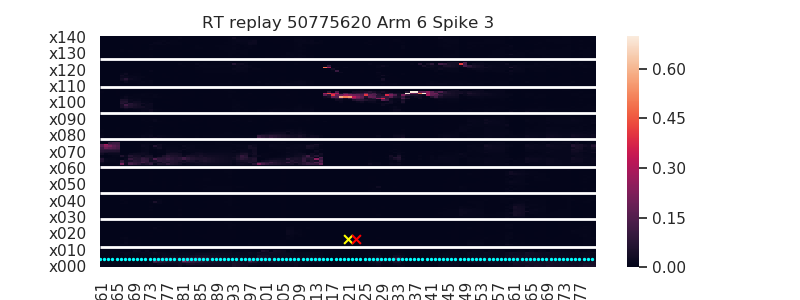

<IPython.core.display.Javascript object>


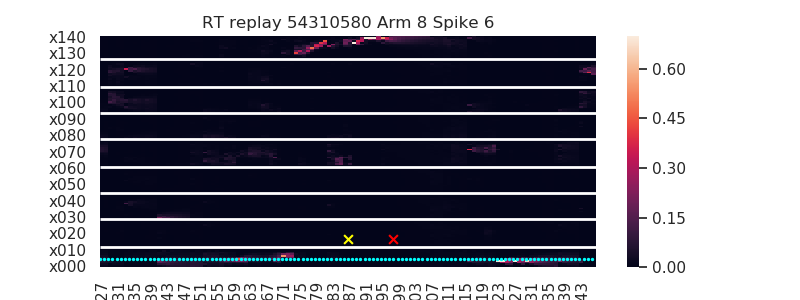

<IPython.core.display.Javascript object>


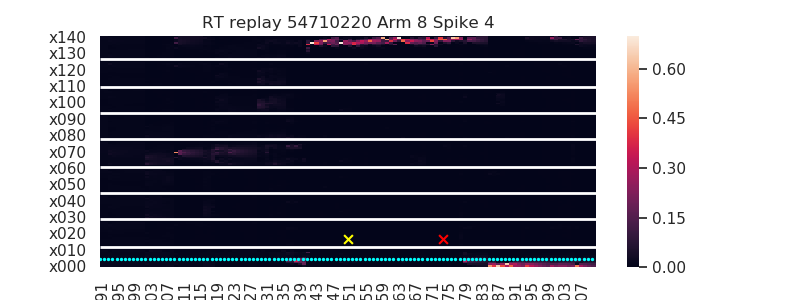

<IPython.core.display.Javascript object>


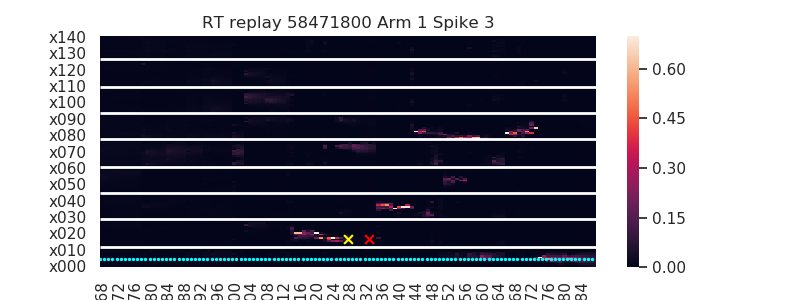

<IPython.core.display.Javascript object>


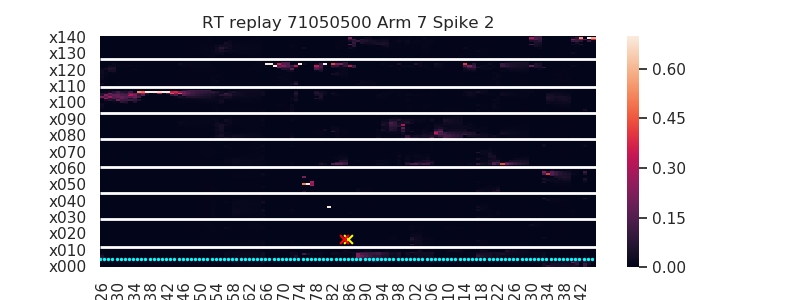

<IPython.core.display.Javascript object>


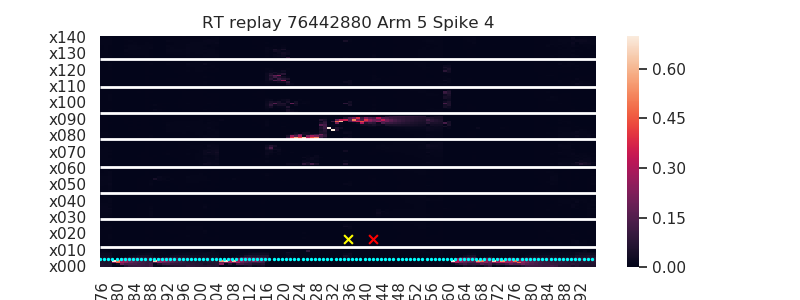

<IPython.core.display.Javascript object>


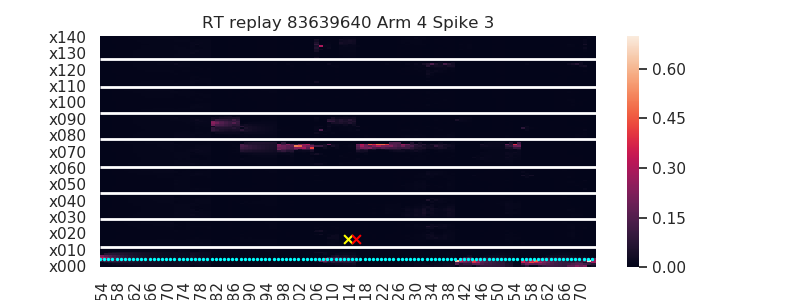

<IPython.core.display.Javascript object>


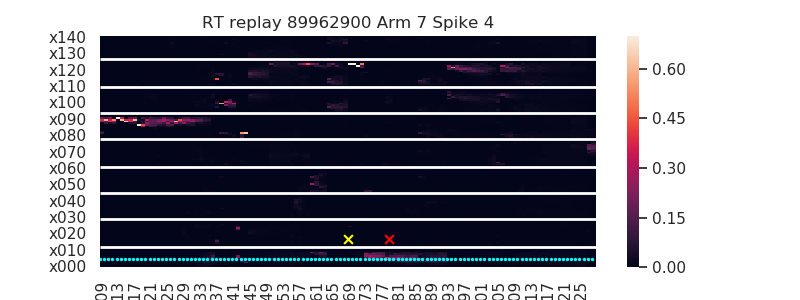

<IPython.core.display.Javascript object>


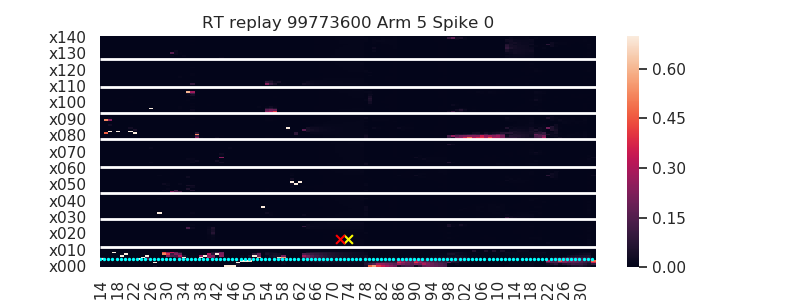

<IPython.core.display.Javascript object>


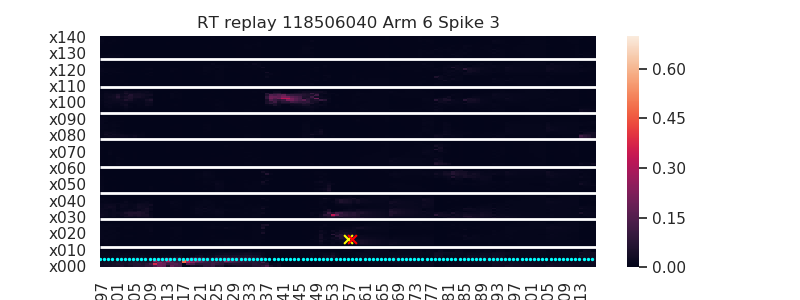

<IPython.core.display.Javascript object>


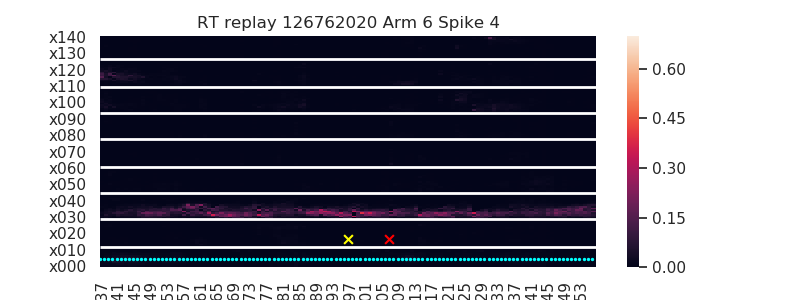

<IPython.core.display.Javascript object>


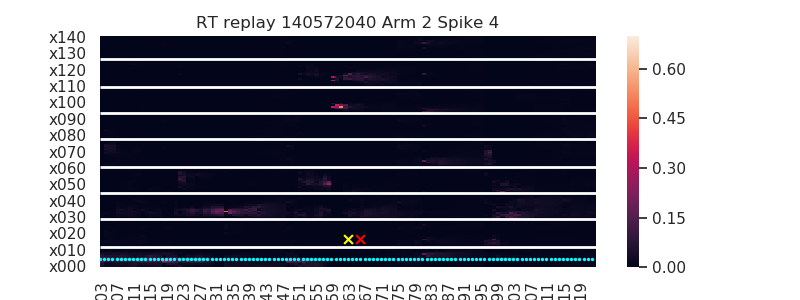

<IPython.core.display.Javascript object>


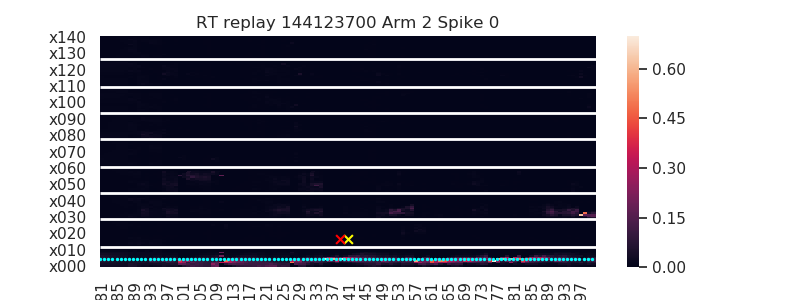

<IPython.core.display.Javascript object>


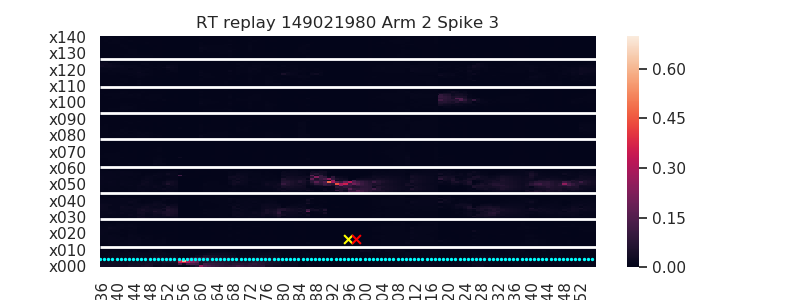

<IPython.core.display.Javascript object>


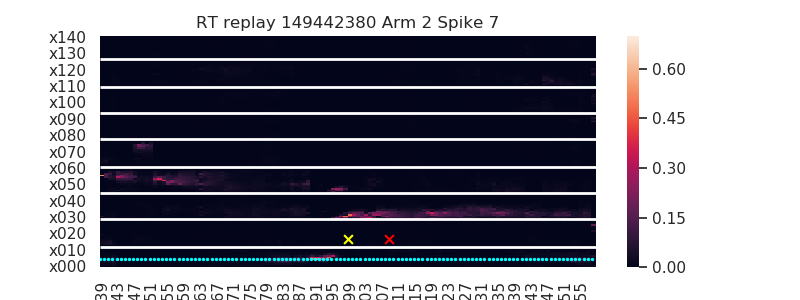

<IPython.core.display.Javascript object>


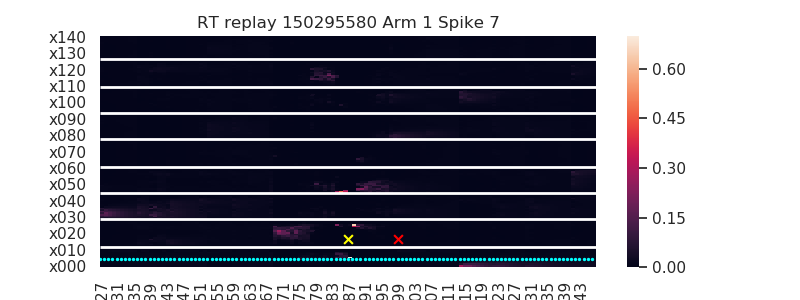

<IPython.core.display.Javascript object>


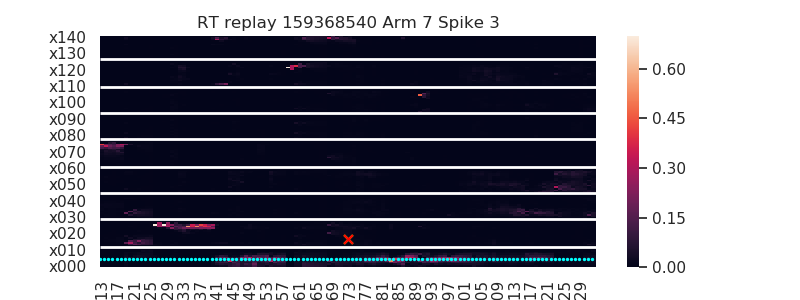

<IPython.core.display.Javascript object>


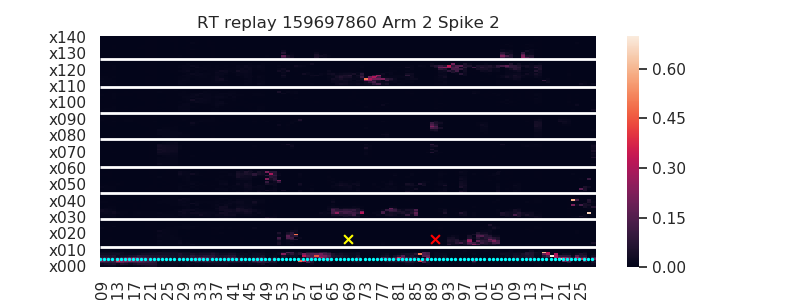

<IPython.core.display.Javascript object>


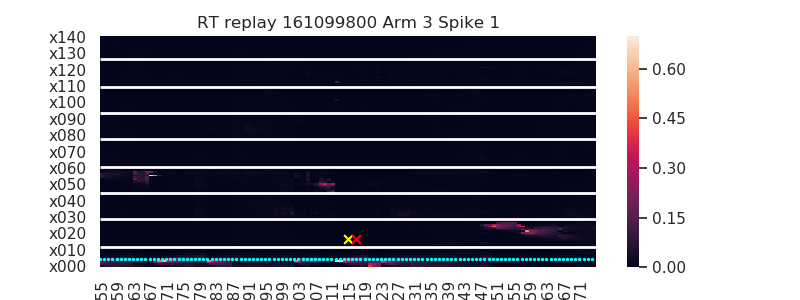

In [735]:
# plot offline decode for messages outside matching ripples
# this seems to work - now need to go through and check each one
# should also add the end of the real-time ripple

# new linearization
arm_coords = [[0,8],[13,25],[29,41],[45,57],[62,74],[78,90],[94,106],[111,123],[127,139]]

summarize_all_rips_offline = True

# now need to plot offline ripples that are mismatched

# set which posteriors file to use
posterior_offline = posteriors.reset_index()
offline_pos = binned_linear_pos.reset_index()
merged_off_post_pos = pd.merge_asof(posterior_offline,offline_pos,on='timestamp',direction='nearest')

#
#rt_msg_outside_rips_arm_sent = rt_msg_outside_rips['posterior_max_arm'].values
#rt_msg_outside_rips_start = rt_msg_outside_rips['timestamp_x'].values
#rt_msg_outside_rips_end = rt_msg_outside_rips['bin_timestamp'].values
#rt_msg_outside_rips_spike = rt_msg_outside_rips['spike_count_rip'].values

# updated for new matching_offline_rips merge timestamp_x -> timestamp_y
# for some reason, final offline rip timestamp is after the decoder has ended - odd
# to deal with this set slice to [:-1]
for index, rip_timestamp in enumerate(rt_msg_outside_rips_start):
    adj_timestamp = rip_timestamp+1958987

    if summarize_all_rips_offline:

        posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > adj_timestamp-30*300) & 
                                            (merged_off_post_pos['timestamp'] < adj_timestamp+30*300)]

        # get timestamp when shortcut message was sent - try to just isolate single ripple
        posterior_to_plot_index = posterior_to_plot.reset_index()
        rt_ripple_start = posterior_to_plot_index.index[(posterior_to_plot_index['timestamp'].values >
                              rt_msg_outside_rips_start[index]+1958987) &
                             (posterior_to_plot_index['timestamp'].values <
                              rt_msg_outside_rips_start[index]+1958987+150)][0]
        rt_ripple_end = posterior_to_plot_index.index[(posterior_to_plot_index['timestamp'].values >
                              rt_msg_outside_rips_end[index]+1958987) &
                             (posterior_to_plot_index['timestamp'].values <
                              rt_msg_outside_rips_end[index]+1958987+150)][0]      

        posterior_offline1 = posterior_to_plot.iloc[:,4:145]
        posterior_offline2 = posterior_offline1.fillna(0)
        post_heatmap = posterior_offline2.transpose()
        post_heatmap = post_heatmap.iloc[::-1]
        
        arm_max = rt_msg_outside_rips_arm_sent[index]
        spk_count = rt_msg_outside_rips_spike[index]
                                
        plt.figure(figsize=(8,3))
        plt.title(f'RT replay {rip_timestamp} Arm {arm_max} Spike {spk_count}')
        ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        ax.hlines([139-10,139-27,139-43,139-59,139-76,139-92,139-108,139-125], lw=2, color='w',*ax.get_xlim())
        ax.scatter(np.arange(0,posterior_to_plot.shape[0]),139-posterior_to_plot['linpos_flat'].values,s=2,alpha=1,color='cyan')
        #ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.25,*ax.get_ylim())
        ax.scatter(rt_ripple_start,124-shortcut_messages,s=40,color='yellow',marker='x')
        ax.scatter(rt_ripple_end,124-shortcut_messages,s=40,color='red',marker='x')

         

In [ ]:
# false positive replays plotted with trials for remy day 20 epoch 2
offline_arm_coords = [[0,8],[13,25],[29,41],[45,57],[62,74],[78,90],[94,106],[111,123],[127,139]]
false_positive_data_plot = false_positive_data.copy()
binned_linear_pos_plot = binned_linear_pos.copy()
binned_linear_pos_plot.reset_index(inplace=True)
mvt_time = binned_linear_pos_plot[binned_linear_pos_plot['linvel_flat'].values>4]

arm_list_int = false_positive_data_plot['rt_max_arm'].values.astype(int)
arm_list_plot = np.zeros((1,len(arm_list_int)))
for i in np.arange(0,len(arm_list_int)):
    arm_list_plot[0][i] = (offline_arm_coords[arm_list_int[i]][1])

# day 20 epoch 2: 1958987
# day 20 epoch 4: 10722379
plt.figure(figsize=(10,4))
plt.scatter(binned_linear_pos_plot['timestamp'].values-1958987,binned_linear_pos_plot['linpos_flat'].values,s=.05,c='black')
# need to make an entry in the summary table with the real-time timestamp
plt.scatter(false_positive_data_plot['ripple_start'].values,arm_list_plot,s=3,c='red')


<IPython.core.display.Javascript object>


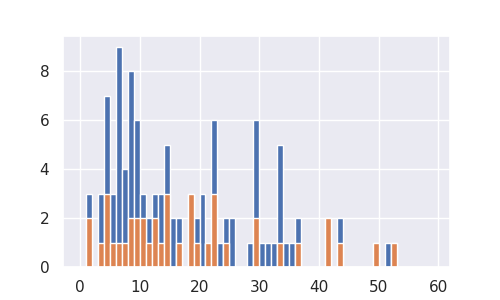

(array([0., 2., 0., 1., 3., 1., 1., 1., 2., 2., 2., 1., 2., 1., 3., 0., 1.,
        0., 3., 1., 0., 1., 3., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 59 Patch objects>)

In [113]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
list(false_positive_data)
#plt.figure(figsize=(5,3))
#plt.hist(false_positive_data['ripple_time_bin'].values,bins=np.arange(0,30))
rt_all_positives_replay = replay_combined_matching[(replay_combined_matching['posterior_max_arm'].values>0)&
                         (replay_combined_matching['posterior_max_arm'].values<10)]
plt.figure(figsize=(5,3))

plt.hist(rt_all_positives_replay['ripple_time_bin'].values,bins=np.arange(0,60))
plt.hist(false_positive_data['ripple_time_bin'].values,bins=np.arange(0,60))

<IPython.core.display.Javascript object>


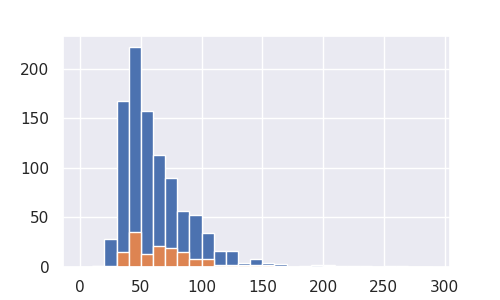

(148, 41)

In [139]:
# plot ripple detection delay for matching rips
rt_all_positives_rip = matching_offline_rips[(matching_offline_rips['posterior_max_arm'].values>0)&
                         (matching_offline_rips['posterior_max_arm'].values<10)]
plt.figure(figsize=(5,3))
plt.hist((matching_offline_rips['adj_timestamp'].values-matching_offline_rips['timestamp_y'].values)/30,
         bins=np.arange(0,300,10))
plt.hist((rt_all_positives_rip['adj_timestamp'].values-rt_all_positives_rip['timestamp_y'].values)/30,
         bins=np.arange(0,300,10)) 
rt_all_positives_rip.shape

In [140]:
# to merge matching_offline_rip (lockout_num) and false_positive_data (realtime_rip)
list(matching_offline_rips)
ripple_delay_FP = pd.DataFrame.merge(matching_offline_rips,false_positive_data,how='inner',
                                            left_on='lockout_num',right_on='realtime_rip',
                                             suffixes=('_riptime', '_FP'))
ripple_delay_FP

,rec_ind_rip_riptime,timestamp_x,time_rip_riptime,lockout_num_riptime,lockout_state_riptime,tets_above_thresh_riptime,big_rip_message_sent_riptime,rec_ind_msg_riptime,bin_timestamp_riptime,spike_timestamp_riptime,...,max_arm_repeats_FP,box_rt,arm1_rt,arm2_rt,arm3_rt,arm4_rt,arm5_rt,arm6_rt,arm7_rt,arm8_rt
0,281027,54667280,1.419312,100,1,6,0,281040,54666750,54667280,...,1,0.023666,0.016599,0.015662,0.029497,0.035439,0.026271,0.027712,0.060075,0.765078
1,393904,60588900,0.782708,147,1,6,0,394058,60591900,60592247,...,1,0.112090,0.017367,0.025169,0.027391,0.554353,0.037550,0.028557,0.175014,0.022509
2,649667,73871880,1.392463,336,1,6,0,649900,73878900,73879580,...,1,0.308174,0.007637,0.018219,0.016535,0.027165,0.014877,0.013780,0.040403,0.553209
3,1022643,93606660,1.348379,565,1,6,0,1022771,93608400,93608940,...,1,0.128841,0.018952,0.023524,0.019189,0.030674,0.025945,0.144322,0.020706,0.587847
4,1047217,94942260,0.873195,579,1,6,0,1047278,94942950,94943380,...,1,0.345339,0.008011,0.009453,0.009878,0.005318,0.015693,0.006576,0.009303,0.590428
5,1138174,99663000,0.856774,631,1,6,0,1138219,99663150,99663700,...,1,0.304449,0.012249,0.012574,0.018175,0.039262,0.513326,0.033991,0.021195,0.044780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2091560,149154880,1.116524,1255,1,6,0,2091713,149157300,149157603,...,1,0.159736,0.093793,0.676551,0.013610,0.007732,0.008907,0.013610,0.015919,0.010141
31,2208266,155516760,0.593111,1327,1,6,0,2208308,155517300,155517620,...,1,0.059627,0.015178,0.070227,0.754724,0.013431,0.016469,0.026586,0.029248,0.014510
32,2216028,155973200,0.232040,1335,1,6,0,2216242,155975700,155976123,...,1,0.212559,0.015744,0.169010,0.507696,0.019121,0.027585,0.015692,0.014356,0.018236


<IPython.core.display.Javascript object>


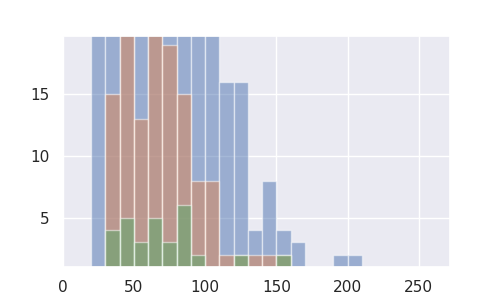

(array([0., 1., 1., 4., 5., 3., 5., 3., 6., 2., 0., 0., 2., 0., 0., 2., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290]),
 <a list of 29 Patch objects>)

In [141]:
plt.figure(figsize=(5,3))
plt.hist((matching_offline_rips['adj_timestamp'].values-matching_offline_rips['timestamp_y'].values)/30,
         bins=np.arange(0,300,10),alpha=0.5)
plt.hist((rt_all_positives_rip['adj_timestamp'].values-rt_all_positives_rip['timestamp_y'].values)/30,
         bins=np.arange(0,300,10),alpha=0.5) 
plt.hist((ripple_delay_FP['adj_timestamp'].values-ripple_delay_FP['timestamp_y'].values)/30,
         bins=np.arange(0,300,10),alpha=0.5)

In [127]:
matching_offline_rips.shape

(885, 41)

<IPython.core.display.Javascript object>


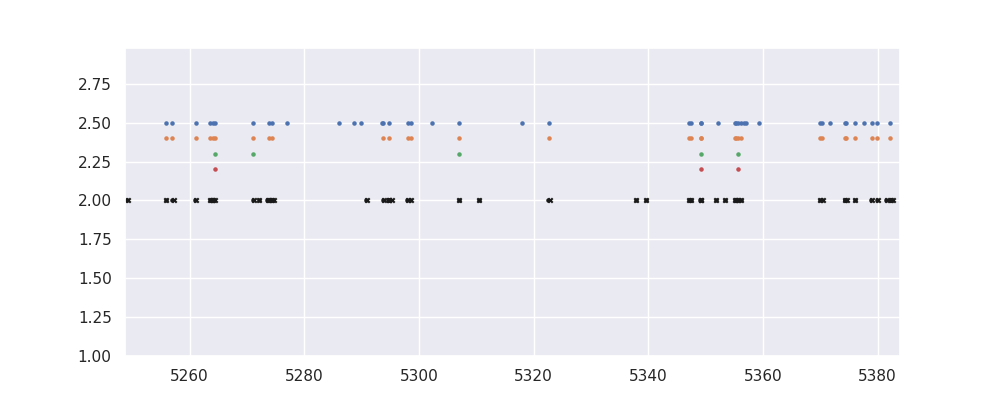

(1, 3)

In [126]:
# okay so the idea is that very long delays between real-time and offline ripple start
# is actually a problem with my matching afterwards
# need to make the ripple scatter plot with true positives and false positives where delay is greater than 125 msec

off_rips_range = rips.copy()
off_rips_range['end_timestamp'] = off_rips_range['timestamp'] + ((off_rips_range['endtime'] - off_rips_range['starttime'])*30000)
off_rips_range

stim_lockout_file = stim_lockout1
realtime_rips_plot = stim_lockout_file[stim_lockout_file['lockout_state']==1]

plt.figure(figsize=(10,4))
plt.scatter(off_rips_range['timestamp'].values/30000,np.repeat(2, 1256),s=5,c='k')
plt.scatter(off_rips_range['end_timestamp'].values/30000,np.repeat(2, 1256),s=10,c='k',marker='x')
plt.scatter((realtime_rips_plot['timestamp'].values+1958987)/30000,np.repeat(2.5, 1215),s=5)
plt.scatter((matching_offline_rips['adj_timestamp'].values)/30000,np.repeat(2.4, 885),s=5)

plt.scatter((rt_all_positives_rip['adj_timestamp'].values)/30000,np.repeat(2.3, 141),s=5)

plt.scatter((ripple_delay_FP['adj_timestamp'].values)/30000,np.repeat(2.2, 42),s=5)

plt.ylim([1,3])

In [ ]:
# not in use - has the wrong column labels for replay_combined_matching
# replay matching for real-time and offline decoder of offline ripple times

# re-run without dealy
# re-run with delay and full session

# make histogram of classification for all replays

#summarize matching between offline and realtime
print('total ripples:',replay_combined_matching.shape[0])

#exact match
matching_replays = (replay_combined_matching[replay_combined_matching['off_max_arm'].values == 
                                              replay_combined_matching['rt_max_arm'].values])

print('exact match:',matching_replays.shape[0])
# non-matching
non_matching = replay_combined_matching[replay_combined_matching['off_max_arm'].values != 
                                       replay_combined_matching['rt_max_arm'].values]
print('non-matching:',non_matching.shape[0])

# count for each arm in realtime replays
print('realtime below 0.5:',non_matching[non_matching['rt_max_arm'] == 99].shape[0])
print('realtime box:',non_matching[non_matching['rt_max_arm'] == 0].shape[0])
print('realtime arm 1:',non_matching[non_matching['rt_max_arm'] == 1].shape[0])
print('realtime arm 2:',non_matching[non_matching['rt_max_arm'] == 2].shape[0])
print('realtime arm 3:',non_matching[non_matching['rt_max_arm'] == 3].shape[0])
print('realtime arm 4:',non_matching[non_matching['rt_max_arm'] == 4].shape[0])
print('realtime arm 5:',non_matching[non_matching['rt_max_arm'] == 5].shape[0])
print('realtime arm 6:',non_matching[non_matching['rt_max_arm'] == 6].shape[0])
print('realtime arm 7:',non_matching[non_matching['rt_max_arm'] == 7].shape[0])
print('realtime arm 8:',non_matching[non_matching['rt_max_arm'] == 8].shape[0])
print('realtime no arm:',non_matching[non_matching['rt_max_arm'] == 98].shape[0])

# offline: no arm above 0.5
mismatch_05_total = non_matching[non_matching['off_max_arm'] == 99]
mismatch_05_rt_box = non_matching[(non_matching['off_max_arm'] == 99) & 
                                  (non_matching['rt_max_arm'] == 0)]
mismatch_05_rt_other = non_matching[(non_matching['off_max_arm'] == 99) & 
                                  (non_matching['rt_max_arm'] == 98)]
mismatch_05_rt_arm = non_matching[(non_matching['off_max_arm'] == 99) & 
                                  (non_matching['rt_max_arm'] > 0) &
                                  (non_matching['rt_max_arm'] < 10)]
print('offline < 0.5, mismatch total:',mismatch_05_total.shape[0])
print('offline < 0.5, realtime box:',mismatch_05_rt_box.shape[0])
print('offline < 0.5, realtime arm:',mismatch_05_rt_arm.shape[0])
print('offline < 0.5, realtime other arm:',mismatch_05_rt_other.shape[0])

# offline: box
mismatch_box_total = non_matching[non_matching['off_max_arm'] == 0]
mismatch_box_rt_05 = non_matching[(non_matching['off_max_arm'] == 0) & 
                                  (non_matching['rt_max_arm'] == 99)]
mismatch_box_rt_other = non_matching[(non_matching['off_max_arm'] == 0) & 
                                  (non_matching['rt_max_arm'] == 98)]
mismatch_box_rt_arm = non_matching[(non_matching['off_max_arm'] == 0) & 
                                   (non_matching['rt_max_arm'] > 0) &
                                   (non_matching['rt_max_arm'] < 10)]
print('offline box, mismatch total:',mismatch_box_total.shape[0])
print('offline box, realtime < 0.5:',mismatch_box_rt_05.shape[0])
print('offline box, realtime arm:',mismatch_box_rt_arm.shape[0])
print('offline box, realtime other arm:',mismatch_box_rt_other.shape[0])

# offline: outer arm
mismatch_arm_total = non_matching[(non_matching['off_max_arm'] > 0)&
                                  (non_matching['off_max_arm'] < 10)]
mismatch_arm_rt_05 = non_matching[(non_matching['off_max_arm'] > 0)&
                                  (non_matching['off_max_arm'] < 10) & 
                                  (non_matching['rt_max_arm'] == 99)]
mismatch_arm_rt_box = non_matching[(non_matching['off_max_arm'] > 0)&
                                   (non_matching['off_max_arm'] < 10) & 
                                   (non_matching['rt_max_arm'] == 0)]
mismatch_arm_rt_other = non_matching[(non_matching['off_max_arm'] > 0)&
                                  (non_matching['off_max_arm'] < 10) & 
                                  (non_matching['rt_max_arm'] == 98)]
mismatch_arm_rt_arm = non_matching[(non_matching['off_max_arm'] > 0)&
                                   (non_matching['off_max_arm'] < 10) & 
                                   (non_matching['rt_max_arm'] > 0) &
                                   (non_matching['rt_max_arm'] < 10)]
print('offline arm, mismatch total:',mismatch_arm_total.shape[0])
print('offline arm, realtime < 0.5:',mismatch_arm_rt_05.shape[0])
print('offline arm, realtime box:',mismatch_arm_rt_box.shape[0])
print('offline arm, realtime arm:',mismatch_arm_rt_arm.shape[0])
print('offline arm, realtime other arm:',mismatch_arm_rt_other.shape[0])

#offline: other outer arm filter
mismatch_other_total = non_matching[non_matching['off_max_arm'] == 98]
mismatch_other_rt_box = non_matching[(non_matching['off_max_arm'] == 98) & 
                                  (non_matching['rt_max_arm'] == 0)]
mismatch_other_rt_05 = non_matching[(non_matching['off_max_arm'] == 98) & 
                                  (non_matching['rt_max_arm'] == 99)]
mismatch_other_rt_arm = non_matching[(non_matching['off_max_arm'] == 98) & 
                                  (non_matching['rt_max_arm'] > 0) &
                                  (non_matching['rt_max_arm'] < 10)]
print('offline other arm filter, mismatch total:',mismatch_other_total.shape[0])
print('offline other arm filter, realtime box:',mismatch_other_rt_box.shape[0])
print('offline other arm filter, realtime 0.5:',mismatch_other_rt_05.shape[0])
print('offline other arm filter, realtime arm:',mismatch_other_rt_arm.shape[0])


print('exact match fraction',np.around((matching_replays.shape[0]/replay_combined_matching.shape[0]),decimals=2))

print('same message fraction',np.around((matching_replays.shape[0]+mismatch_05_rt_box.shape[0]+
                                         mismatch_box_rt_05.shape[0]+mismatch_other_rt_box.shape[0]+
                                         mismatch_other_rt_05.shape[0])/replay_combined_matching.shape[0],decimals=2))

print('false negative',np.around((mismatch_arm_rt_05.shape[0]+mismatch_arm_rt_box.shape[0]+
                                 mismatch_arm_rt_other.shape[0])/replay_combined_matching.shape[0],decimals=2))

false_positive_data = pd.concat([mismatch_05_rt_arm, mismatch_box_rt_arm, mismatch_arm_rt_arm,mismatch_other_rt_arm])

print('false positive count',false_positive_data.shape[0])

replay_false_positive = (mismatch_05_rt_arm.shape[0]+mismatch_box_rt_arm.shape[0]+
                         mismatch_arm_rt_arm.shape[0]+mismatch_other_rt_arm.shape[0])

print('false positive',np.around(replay_false_positive/replay_combined_matching.shape[0],decimals=2))

# false positives of sent messages
all_sent_message = replay_combined_matching[(replay_combined_matching['rt_max_arm'] > 0) & 
                                           (replay_combined_matching['rt_max_arm'] < 10)]
print('false positive messages:',np.around(replay_false_positive/all_sent_message.shape[0],decimals=2))

In [144]:
# compare 150-250 filter vs 100-400 filter
        # original 100-400 Hz ripple filter
origin_NUMERATOR = [2.435723358568172431e-02,
                           -1.229133831328424326e-01,
                           2.832924715801946602e-01,
                           -4.629092463232863941e-01,
                           6.834398182647745124e-01,
                           -8.526143367711925825e-01,
                           8.137704425816699727e-01,
                           -6.516133270563613245e-01,
                           4.138371933419512372e-01,
                           2.165520280363200556e-14,
                           -4.138371933419890403e-01,
                           6.516133270563868596e-01,
                           -8.137704425816841836e-01,
                           8.526143367711996879e-01,
                           -6.834398182647782871e-01,
                           4.629092463232882815e-01,
                           -2.832924715801954929e-01,
                           1.229133831328426407e-01,
                           -2.435723358568174512e-02]

origin_DENOMINATOR = [1.000000000000000000e+00,
                             -7.449887056735371438e+00,
                             2.866742370538527496e+01,
                             -7.644272470167831557e+01,
                             1.585893197862293391e+02,
                             -2.703338821178639932e+02,
                             3.898186201116285474e+02,
                             -4.840217978093359079e+02,
                             5.230782138295531922e+02,
                             -4.945387299274730140e+02,
                             4.094389697124813665e+02,
                             -2.960738943482194827e+02,
                             1.857150345772943751e+02,
                             -9.980204002570326338e+01,
                             4.505294594295533273e+01,
                             -1.655156422615593215e+01,
                             4.683913633549676270e+00,
                            -9.165841559639211766e-01,
                            9.461443242601841330e-02]

        # anna's 150-250 Hz ripple filter
anna_NUMERATOR = [0.00129180641792292,
        -0.0129686462053354,0.0649860663276546,
        -0.213040690450758,0.505568917616276,
        -0.907525263464183,1.24408910068877,
        -1.26054939315621,0.806575646754607,
        0,-0.806575646754607,
        1.26054939315621,-1.24408910068877,
        0.907525263464183,-0.505568917616276,
        0.213040690450758,-0.0649860663276546,
        0.0129686462053354,-0.00129180641792292]

anna_DENOMINATOR = [1,
        -11.7211644621401,69.4141606894030,
        -272.943693781472,793.733182246242,
        -1805.56956364536,3320.66911787227,
        -5039.18721590951,6388.83865252807,
        -6813.09822646561,6124.33733155433,
        -4630.48270472608,2924.84894521595,
        -1524.33752473424,642.249494056762,
        -211.659943388859,51.5861946277428,
        -8.34803786957350,0.682686766261136]


<IPython.core.display.Javascript object>


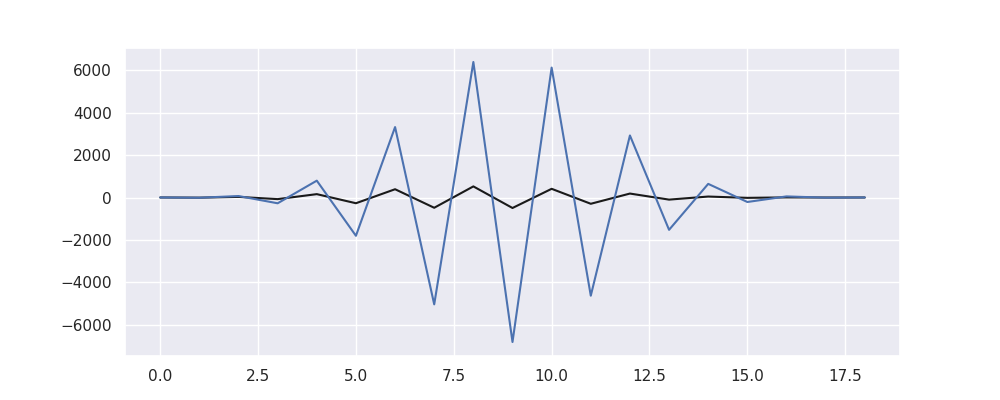

In [155]:
plt.figure(figsize=(10,4))
#plt.plot(np.arange(0,19),origin_NUMERATOR,c='k')
#plt.plot(np.arange(0,19),anna_NUMERATOR,c='b')

plt.plot(np.arange(0,19),origin_DENOMINATOR,c='k')
plt.plot(np.arange(0,19),anna_DENOMINATOR,c='b')


In [168]:
receive_encoding_spike = timing[timing['label']=='dec_recv']
receive_decoded_spike = timing[timing['label']=='dec_finish']
tet_30_enc_recv = receive_encoding_spike[receive_encoding_spike['elec_grp_id']==1]
tet_30_dec_recv = receive_decoded_spike[receive_decoded_spike['elec_grp_id']==1]

joined_enc_dec = tet_30_enc_recv.set_index('timestamp').join(tet_30_dec_recv.set_index('timestamp'), lsuffix='_enc', rsuffix='_dec')
joined_enc_dec['timing_diff'] = joined_enc_dec['wtime_adj_dec'] - joined_enc_dec['wtime_adj_enc']
#joined_enc_dec[joined_enc_dec['elec_grp_id_dec']>0]
joined_enc_dec

,rec_ind_enc,elec_grp_id_enc,rank_enc,label_enc,datatype_enc,wtime_raw_enc,wtime_adj_enc,rec_ind_dec,elec_grp_id_dec,rank_dec,label_dec,datatype_dec,wtime_raw_dec,wtime_adj_dec,timing_diff
timestamp,,,,,,,,,,,,,,,
12,49,1,1,dec_recv,2,1.588093e+09,1.588093e+09,51.0,1.0,1.0,dec_finish,2.0,1.588093e+09,1.588093e+09,0.000025
22,73,1,1,dec_recv,2,1.588093e+09,1.588093e+09,75.0,1.0,1.0,dec_finish,2.0,1.588093e+09,1.588093e+09,0.000031
32,85,1,1,dec_recv,2,1.588093e+09,1.588093e+09,87.0,1.0,1.0,dec_finish,2.0,1.588093e+09,1.588093e+09,0.000019
42,96,1,1,dec_recv,2,1.588093e+09,1.588093e+09,98.0,1.0,1.0,dec_finish,2.0,1.588093e+09,1.588093e+09,0.000019
52,107,1,1,dec_recv,2,1.588093e+09,1.588093e+09,109.0,1.0,1.0,dec_finish,2.0,1.588093e+09,1.588093e+09,0.000018
62,118,1,1,dec_recv,2,1.588093e+09,1.588093e+09,120.0,1.0,1.0,dec_finish,2.0,1.588093e+09,1.588093e+09,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698937,1029013,1,1,dec_recv,2,1.588095e+09,1.588095e+09,1029014.0,1.0,1.0,dec_finish,2.0,1.588095e+09,1.588095e+09,0.000062
698951,1029046,1,1,dec_recv,2,1.588095e+09,1.588095e+09,1029051.0,1.0,1.0,dec_finish,2.0,1.588095e+09,1.588095e+09,0.002633


<IPython.core.display.Javascript object>


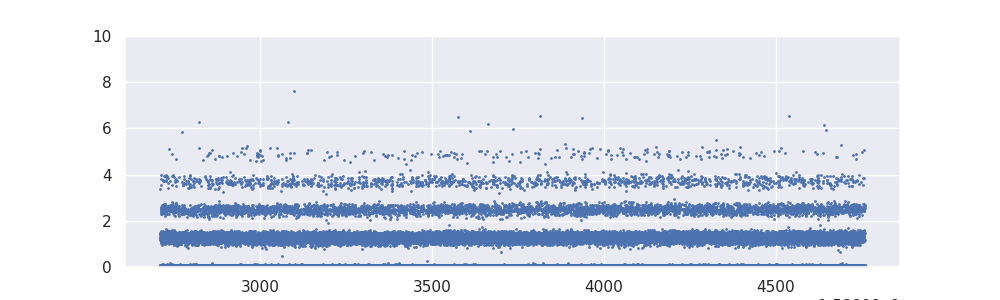

(0, 10)

In [169]:
# moved timing message
plt.figure(figsize=(10,3))
plt.scatter(joined_enc_dec['wtime_adj_enc'].values,(joined_enc_dec['timing_diff'].values*1000),s=1)
#plt.hist(decoder_data1['real_pos'].values,bins=136)
#decoder_data.shape
plt.ylim(0,10)